In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import time
from scipy import signal

In [2]:
import numpy as np
from scipy import signal
import numbers
from inspect import isfunction
import datetime

!pip install seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 10)})

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


# Strategy parameters

In [3]:
bndw_m = 120
bndw_v1 = 300
bndw_v2 = 600

entry = 2
exit = 2

In [75]:
x = pd.read_csv('USA500_market_open.csv')
y = pd.read_csv('USA500.csv')

In [76]:
x

,Unnamed: 0,Timestamp,Bid price,Ask price,Bid volume,Ask volume
0,0,2013-01-02 15:50:03.590,1426.190,1426.190,1.00000,1.00000
1,1,2013-01-02 15:50:16.559,1439.340,1439.340,1.00000,1.00000
2,2,2013-01-02 15:50:26.637,1440.720,1440.720,1.00000,1.00000
3,3,2013-01-02 15:50:38.210,1441.200,1441.200,1.00000,1.00000
4,4,2013-01-02 15:50:42.624,1442.460,1442.460,1.00000,1.00000
...,...,...,...,...,...,...
54424795,54424795,2021-12-31 21:59:59.767,4766.933,4767.449,0.00225,0.00225
54424796,54424796,2021-12-31 21:59:59.831,4766.943,4767.466,0.00037,0.00037
54424797,54424797,2021-12-31 21:59:59.881,4767.954,4768.464,0.00225,0.00225
54424798,54424798,2021-12-31 21:59:59.932,4767.451,4767.949,0.00225,0.00225


In [77]:
y

,Timestamp,Bid price,Ask price,Bid volume,Ask volume
0,2013-01-01 06:44:03:108,1426.190,1426.190,1.00000,1.00000
1,2013-01-02 15:50:03:590,1426.190,1426.190,1.00000,1.00000
2,2013-01-02 15:50:16:559,1439.340,1439.340,1.00000,1.00000
3,2013-01-02 15:50:26:637,1440.720,1440.720,1.00000,1.00000
4,2013-01-02 15:50:38:210,1441.200,1441.200,1.00000,1.00000
...,...,...,...,...,...
99923635,2021-12-31 22:14:55:297,4772.336,4773.064,0.00225,0.00225
99923636,2021-12-31 22:14:55:726,4772.145,4772.858,0.00262,0.00225
99923637,2021-12-31 22:14:55:777,4772.148,4772.861,0.00225,0.00225
99923638,2021-12-31 22:14:57:989,4772.342,4772.869,0.00225,0.00037


# Data import

In [5]:
Signal = pd.read_csv('USA500_db_t_bndw_m_{}_rwindow_{}_market_open.csv'.format(bndw_m, bndw_v1))
Signal2 = pd.read_csv('USA500_db_t_bndw_m_{}_rwindow_{}_market_open.csv'.format(bndw_m, bndw_v2))
Signal.columns = ['remove', 'Price', 't', 'db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)]
Signal2.columns = ['remove', 'Price', 't', 'db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)]
Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)] = Signal2['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)]
Signal.drop(columns=['remove'], inplace=True)

In [6]:
Signal.t = pd.to_datetime(Signal.t)

In [79]:
Signal

,Price,t,db_t_bndw_m_120_rwindow_300,db_t_bndw_m_120_rwindow_600,strat_300,strat_600,strat_300_ret,strat_600_ret,day,money,ret
0,1453.810,2013-01-02 16:00:53.162,3.333904,3.333904,0,0,NaN,NaN,2013-01-02,NaN,NaN
1,1453.850,2013-01-02 16:00:58.449,3.333904,3.333904,0,0,1.0,1.0,2013-01-02,1.000028,1.000028
2,1453.800,2013-01-02 16:01:08.103,3.333904,3.333904,0,0,1.0,1.0,2013-01-02,0.999966,0.999966
3,1453.760,2013-01-02 16:01:10.410,3.333904,3.333904,0,0,1.0,1.0,2013-01-02,0.999972,0.999972
4,1453.920,2013-01-02 16:01:21.187,3.333904,3.333904,0,0,1.0,1.0,2013-01-02,1.000110,1.000110
...,...,...,...,...,...,...,...,...,...,...,...
10733109,1881.416,2016-01-15 16:53:56.242,1.091188,-1.591960,0,0,1.0,1.0,2016-01-15,0.999883,0.999883
10733110,1881.604,2016-01-15 16:53:56.355,1.091188,-1.591960,0,0,1.0,1.0,2016-01-15,1.000100,1.000100
10733111,1881.618,2016-01-15 16:53:56.445,1.091188,-1.591960,0,0,1.0,1.0,2016-01-15,1.000007,1.000007
10733112,1881.419,2016-01-15 16:53:56.617,1.091188,-1.591960,0,0,1.0,1.0,2016-01-15,0.999894,0.999894


In [8]:
Signal.drop(index=np.arange(99), inplace=True)
Signal.reset_index(drop=True, inplace=True)
Signal.fillna(method='ffill', inplace=True)

In [9]:
Signal.ret = np.log(Signal.Price) - np.log(Signal.Price.shift(1))

/tmp/ipykernel_162/3484301899.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Signal.ret = np.log(Signal.Price) - np.log(Signal.Price.shift(1))


# Strategy calculation

In [10]:
%%time

print(datetime.datetime.today())

Signal['strat_{}'.format(bndw_v1)] = 0
Signal['strat_{}'.format(bndw_v2)] = 0

long_bndwv1_entry = []
long_bndwv1_exit = []
short_bndwv1_entry = []
short_bndwv1_exit = []

long_bndwv2_entry = []
long_bndwv2_exit = []
short_bndwv2_entry = []
short_bndwv2_exit = []

strat_ret_bndwv1_close = []
strat_ret_bndwv2_close = []

k = 0
for j in range(1, len(Signal)):

    if j < k:
        continue
        
    elif Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j-1] < entry and Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j] > entry:
        ind = np.flatnonzero(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j:].values < exit)
        if len(ind) > 0:
            ind = ind[0]
        else:
            ind = len(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j:]) - 1

        k = j + ind

        if len (Signal.iloc[j:k]) > 0:
            long_bndwv1_entry.append(Signal.t.iloc[j])
            Signal['strat_{}'.format(bndw_v1)].iloc[j:k] = 1
            long_bndwv1_exit.append(Signal.t.iloc[k])
            strat_ret_bndwv1_close.append((Signal.ret.iloc[j:k].values + 1).cumprod()[-1])
            
        else:
            continue

    elif Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j-1] > -entry and Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j] < -entry:
        ind = np.flatnonzero(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j:].values > -exit)

        if len(ind) > 0:
            ind = ind[0]
        else:
            ind = len(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v1)].iloc[j:]) - 1

        k = j + ind

        if len (Signal.iloc[j:k]) > 0:
            short_bndwv1_entry.append(Signal.t.iloc[j])
            Signal['strat_{}'.format(bndw_v1)].iloc[j:k] = -1
            short_bndwv1_exit.append(Signal.t.iloc[k])
            strat_ret_bndwv1_close.append((1/(Signal.ret.iloc[j:k].values + 1)).cumprod()[-1])            

        else:
            continue

k = 0
for j in range(1, len(Signal)):

    if j < k:
        continue

    elif Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j-1] < entry and Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j] > entry:
        ind = np.flatnonzero(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j:].values < exit)

        if len(ind) > 0:
            ind = ind[0]
        else:
            ind = len(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j:]) - 1

        k = j + ind

        if len (Signal.iloc[j:k]) > 0:
            long_bndwv2_entry.append(Signal.t.iloc[j])
            Signal['strat_{}'.format(bndw_v2)].iloc[j:k] = 1
            long_bndwv2_exit.append(Signal.t.iloc[k])
            strat_ret_bndwv2_close.append((Signal.ret.iloc[j:k].values + 1).cumprod()[-1])
            
        else:
            continue

    elif Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j-1] > -entry and Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j] < -entry:
        ind = np.flatnonzero(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j:].values > -exit)

        if len(ind) > 0:
            ind = ind[0]

        else:
            ind = len(Signal['db_t_bndw_m_{}_rwindow_{}'.format(bndw_m, bndw_v2)].iloc[j:]) - 1
        k = j + ind

        if len (Signal.iloc[j:k]) > 0:
            short_bndwv2_entry.append(Signal.t.iloc[j])
            Signal['strat_{}'.format(bndw_v2)].iloc[j:k] = -1
            short_bndwv2_exit.append(Signal.t.iloc[k])
            strat_ret_bndwv2_close.append((1/(Signal.ret.iloc[j:k].values + 1)).cumprod()[-1])
            
        else:
            continue

/srv/conda/envs/saturn/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


2022-01-09 22:00:24.466232
CPU times: user 11min 10s, sys: 1min 59s, total: 13min 9s
Wall time: 13min 9s


# Duration of trades and rebase on trading day

In [11]:
# Duration of all trades
strat_bndwv1_entry = np.append(long_bndwv1_entry, short_bndwv1_entry)
strat_bndwv2_entry = np.append(long_bndwv2_entry, short_bndwv2_entry)
strat_bndwv1_exit = np.append(long_bndwv1_exit, short_bndwv1_exit)
strat_bndwv2_exit = np.append(long_bndwv2_exit, short_bndwv2_exit)

strat_bndwv1_entry = np.sort(strat_bndwv1_entry)
strat_bndwv2_entry = np.sort(strat_bndwv2_entry)
strat_bndwv1_exit = np.sort(strat_bndwv1_exit)
strat_bndwv2_exit = np.sort(strat_bndwv2_exit)

strat_bndwv1_durations = strat_bndwv1_exit - strat_bndwv1_entry
strat_bndwv2_durations = strat_bndwv2_exit - strat_bndwv2_entry

In [12]:
# Rebase of duration of all trades on the length of the trading day (6.5 hours)
# bndw_v1
business_days = np.busday_count(pd.Series(strat_bndwv1_entry).dt.date.values.astype('datetime64[D]'), pd.Series(strat_bndwv1_exit).dt.date.values.astype('datetime64[D]'))
cond = (pd.Series(pd.Series(strat_bndwv1_durations).dt.to_pytimedelta()).dt.seconds >= 63000)
business_days2 = np.where(cond, business_days - 1, business_days)
days = np.where(cond, pd.Series(strat_bndwv1_durations).dt.days.values + 1, pd.Series(strat_bndwv1_durations).dt.days.values)
weekend = np.logical_not(days == business_days)

strat_bndwv1_rebased_durations = ((pd.Series(strat_bndwv1_durations).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(strat_bndwv1_durations).dt.days - (business_days2))*24)/6.5).values

# bndw_v2
business_days = np.busday_count(pd.Series(strat_bndwv2_entry).dt.date.values.astype('datetime64[D]'), pd.Series(strat_bndwv2_exit).dt.date.values.astype('datetime64[D]'))
cond = (pd.Series(pd.Series(strat_bndwv2_durations).dt.to_pytimedelta()).dt.seconds >= 63000)
business_days2 = np.where(cond, business_days - 1, business_days)
days = np.where(cond, pd.Series(strat_bndwv2_durations).dt.days.values + 1, pd.Series(strat_bndwv2_durations).dt.days.values)
weekend = np.logical_not(days == business_days)

strat_bndwv2_rebased_durations = ((pd.Series(strat_bndwv2_durations).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(strat_bndwv2_durations).dt.days - (business_days2))*24)/6.5).values

In [13]:
# Long and short durations
long_bndwv1_exit = np.array(long_bndwv1_exit)
long_bndwv1_entry = np.array(long_bndwv1_entry)
short_bndwv1_exit = np.array(short_bndwv1_exit)
short_bndwv1_entry = np.array(short_bndwv1_entry)
long_bndwv2_exit = np.array(long_bndwv2_exit)
long_bndwv2_entry = np.array(long_bndwv2_entry)
short_bndwv2_exit = np.array(short_bndwv2_exit)
short_bndwv2_entry = np.array(short_bndwv2_entry)

# Durations
durations_long_bndwv1 = long_bndwv1_exit - long_bndwv1_entry
durations_short_bndwv1 = short_bndwv1_exit - short_bndwv1_entry
durations_long_bndwv2 = long_bndwv2_exit - long_bndwv2_entry
durations_short_bndwv2 = short_bndwv2_exit - short_bndwv2_entry

In [14]:
# Rebased long/short durations
# bndw_v1
# Long
if len(long_bndwv1_entry) == 0:
    long_bndwv1_rebased_durations = [0]
else:
    business_days = np.busday_count(pd.Series(long_bndwv1_entry).dt.date.values.astype('datetime64[D]'), pd.Series(long_bndwv1_exit).dt.date.values.astype('datetime64[D]'))
    cond = (pd.Series(pd.Series(durations_long_bndwv1).dt.to_pytimedelta()).dt.seconds >= 63000)
    business_days2 = np.where(cond, business_days - 1, business_days)
    days = np.where(cond, pd.Series(durations_long_bndwv1).dt.days.values + 1, pd.Series(durations_long_bndwv1).dt.days.values)
    weekend = np.logical_not(days == business_days)

    long_bndwv1_rebased_durations = ((pd.Series(durations_long_bndwv1).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(durations_long_bndwv1).dt.days - (business_days2))*24)/6.5).values

# Short
if len(short_bndwv1_entry) == 0:
    short_bndwv1_rebased_durations = [0]
else:
    business_days = np.busday_count(pd.Series(short_bndwv1_entry).dt.date.values.astype('datetime64[D]'), pd.Series(short_bndwv1_exit).dt.date.values.astype('datetime64[D]'))
    cond = (pd.Series(pd.Series(durations_short_bndwv1).dt.to_pytimedelta()).dt.seconds >= 63000)
    business_days2 = np.where(cond, business_days - 1, business_days)
    days = np.where(cond, pd.Series(durations_short_bndwv1).dt.days.values + 1, pd.Series(durations_short_bndwv1).dt.days.values)
    weekend = np.logical_not(days == business_days)

    short_bndwv1_rebased_durations = ((pd.Series(durations_short_bndwv1).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(durations_short_bndwv1).dt.days - (business_days2))*24)/6.5).values

# bndw_v2
# Long
if len(long_bndwv2_entry) == 0:
    long_bndwv2_rebased_durations = [0]
else:
    business_days = np.busday_count(pd.Series(long_bndwv2_entry).dt.date.values.astype('datetime64[D]'), pd.Series(long_bndwv2_exit).dt.date.values.astype('datetime64[D]'))
    cond = (pd.Series(pd.Series(durations_long_bndwv2).dt.to_pytimedelta()).dt.seconds >= 63000)
    business_days2 = np.where(cond, business_days - 1, business_days)
    days = np.where(cond, pd.Series(durations_long_bndwv2).dt.days.values + 1, pd.Series(durations_long_bndwv2).dt.days.values)
    weekend = np.logical_not(days == business_days)

    long_bndwv2_rebased_durations = ((pd.Series(durations_long_bndwv2).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(durations_long_bndwv2).dt.days - (business_days2))*24)/6.5).values

# Short
if len(short_bndwv2_entry) == 0:
    short_bndwv2_rebased_durations = [0]
else:
    business_days = np.busday_count(pd.Series(short_bndwv2_entry).dt.date.values.astype('datetime64[D]'), pd.Series(short_bndwv2_exit).dt.date.values.astype('datetime64[D]'))
    cond = (pd.Series(pd.Series(durations_short_bndwv2).dt.to_pytimedelta()).dt.seconds >= 63000)
    business_days2 = np.where(cond, business_days - 1, business_days)
    days = np.where(cond, pd.Series(durations_short_bndwv2).dt.days.values + 1, pd.Series(durations_short_bndwv2).dt.days.values)
    weekend = np.logical_not(days == business_days)

    short_bndwv2_rebased_durations = ((pd.Series(durations_short_bndwv2).dt.total_seconds()/3600 - 17.5*business_days - weekend*(pd.Series(durations_short_bndwv2).dt.days - (business_days2))*24)/6.5).values

del business_days
del cond 
del business_days2
del days
del weekend

# Mean durations long/short

In [15]:
# Mean durations of rebased durations
mean_dur_long_bndwv1 = np.mean(long_bndwv1_rebased_durations)
mean_dur_short_bndwv1 = np.mean(short_bndwv1_rebased_durations)
mean_dur_long_bndwv2 = np.mean(long_bndwv2_rebased_durations)
mean_dur_short_bndwv2 = np.mean(short_bndwv2_rebased_durations)

days_long_bndwv1 = int(mean_dur_long_bndwv1)
hours_long_bndwv1 = (mean_dur_long_bndwv1 % 1) * 6.5
minutes_long_bndwv1 = (hours_long_bndwv1 % 1) * 60
seconds_long_bndwv1 = (minutes_long_bndwv1 % 1) * 60
str_mean_dur_long_bndwv1 = '{} days, {} hours, {} minutes, {} seconds'.format(days_long_bndwv1,
                                                                              int(hours_long_bndwv1),
                                                                              int(minutes_long_bndwv1),
                                                                              round(seconds_long_bndwv1, 3))

days_short_bndwv1 = int(mean_dur_short_bndwv1)
hours_short_bndwv1 = (mean_dur_short_bndwv1 % 1) * 6.5
minutes_short_bndwv1 = (hours_short_bndwv1 % 1) * 60
seconds_short_bndwv1 = (minutes_short_bndwv1 % 1) * 60
str_mean_dur_short_bndwv1 = '{} days, {} hours, {} minutes, {} seconds'.format(days_short_bndwv1,
                                                                              int(hours_short_bndwv1),
                                                                              int(minutes_short_bndwv1),
                                                                              round(seconds_short_bndwv1, 3))

days_long_bndwv2 = int(mean_dur_long_bndwv2)
hours_long_bndwv2 = (mean_dur_long_bndwv2 % 1) * 6.5
minutes_long_bndwv2 = (hours_long_bndwv2 % 1) * 60
seconds_long_bndwv2 = (minutes_long_bndwv2 % 1) * 60
str_mean_dur_long_bndwv2 = '{} days, {} hours, {} minutes, {} seconds'.format(days_long_bndwv2,
                                                                              int(hours_long_bndwv2),
                                                                              int(minutes_long_bndwv2),
                                                                              round(seconds_long_bndwv2, 3))

days_short_bndwv2 = int(mean_dur_short_bndwv2)
hours_short_bndwv2 = (mean_dur_short_bndwv2 % 1) * 6.5
minutes_short_bndwv2 = (hours_short_bndwv2 % 1) * 60
seconds_short_bndwv2 = (minutes_short_bndwv2 % 1) * 60
str_mean_dur_short_bndwv2 = '{} days, {} hours, {} minutes, {} seconds'.format(days_short_bndwv2,
                                                                              int(hours_short_bndwv2),
                                                                              int(minutes_short_bndwv2),
                                                                              round(seconds_short_bndwv2, 3))

print('Long average duration {}: {}'.format(bndw_v1, str_mean_dur_long_bndwv1))
print('Short average duration {}: {}'.format(bndw_v1, str_mean_dur_short_bndwv1))
print('Long average duration {}: {}'.format(bndw_v2, str_mean_dur_long_bndwv2))
print('Short average duration {}: {}'.format(bndw_v2, str_mean_dur_short_bndwv2))

Long average duration 300: 0 days, 0 hours, 5 minutes, 53.671 seconds
Short average duration 300: 0 days, 0 hours, 4 minutes, 45.43 seconds
Long average duration 600: 0 days, 0 hours, 7 minutes, 8.738 seconds
Short average duration 600: 0 days, 0 hours, 5 minutes, 56.338 seconds


# Strategy returns

In [16]:
Signal['strat_{}_ret'.format(bndw_v1)] = Signal.ret*Signal['strat_{}'.format(bndw_v1)] + 1
Signal['strat_{}_ret'.format(bndw_v1)] = np.where(Signal['strat_{}'.format(bndw_v1)] == -1, 1/(Signal.ret + 1), Signal['strat_{}_ret'.format(bndw_v1)])
Signal['strat_{}_ret'.format(bndw_v2)] = Signal.ret*Signal['strat_{}'.format(bndw_v2)] + 1
Signal['strat_{}_ret'.format(bndw_v2)] = np.where(Signal['strat_{}'.format(bndw_v2)] == -1, 1/(Signal.ret + 1), Signal['strat_{}_ret'.format(bndw_v2)])

# Sharpe

In [17]:
strat_ret_bndwv1_close = np.array(strat_ret_bndwv1_close)
strat_ret_bndwv2_close = np.array(strat_ret_bndwv2_close)

Signal['day'] = Signal.t.dt.date
daily_ret_bndwv1 = Signal.groupby('day')['strat_{}_ret'.format(bndw_v1)].prod()
daily_ret_bndwv2 = Signal.groupby('day')['strat_{}_ret'.format(bndw_v2)].prod()

annualised_ret_bndwv1 = daily_ret_bndwv1.mean()**252 - 1
annualised_ret_bndwv2 = daily_ret_bndwv2.mean()**252 - 1

strat_bndw1_annualised_vol = daily_ret_bndwv1.std()*np.sqrt(252)
strat_bndw2_annualised_vol = daily_ret_bndwv2.std()*np.sqrt(252)

sharpe_bndwv1 = annualised_ret_bndwv1/strat_bndw1_annualised_vol
sharpe_bndwv2 = annualised_ret_bndwv2/strat_bndw2_annualised_vol

print('Sharpe {}: {}'.format(bndw_v1, sharpe_bndwv1))
print('Sharpe {}: {}'.format(bndw_v2, sharpe_bndwv2))
print('\nvol 1: {}\nvol 2: {}'.format(strat_bndw1_annualised_vol, strat_bndw2_annualised_vol))
print('\nret 1: {}\nret 2: {}'.format(annualised_ret_bndwv1, annualised_ret_bndwv2))

Sharpe 300: 0.338332583981717
Sharpe 600: -0.11518972676214269

vol 1: 0.08193218340274103
vol 2: 0.08493719721899558

ret 1: 0.02772032732191332
ret 2: -0.009783892539598327


# Other metrics

In [18]:
avg_ret_bndwv1 = (np.mean(strat_ret_bndwv1_close) - 1)*100
avg_ret_bndwv2 = (np.mean(strat_ret_bndwv2_close) - 1)*100
profitable_trades_bndwv1 = (len(np.where(strat_ret_bndwv1_close >= 1)[0])/len(strat_ret_bndwv1_close))*100
profitable_trades_bndwv2 = (len(np.where(strat_ret_bndwv2_close >= 1)[0])/len(strat_ret_bndwv2_close))*100
avg_win_bndwv1 = (np.mean(strat_ret_bndwv1_close[np.where(strat_ret_bndwv1_close > 1)]) - 1)*100
avg_win_bndwv2 = (np.mean(strat_ret_bndwv2_close[np.where(strat_ret_bndwv2_close > 1)]) - 1)*100
avg_loss_bndwv1 = (np.mean(strat_ret_bndwv1_close[np.where(strat_ret_bndwv1_close < 1)]) - 1)*100
avg_loss_bndwv2 = (np.mean(strat_ret_bndwv2_close[np.where(strat_ret_bndwv2_close < 1)]) - 1)*100

print('Mean return bndwv1:', avg_ret_bndwv1)
print('Mean return bndwv2:', avg_ret_bndwv2)
print('% of profitable trades bndwv1:', profitable_trades_bndwv1)
print('% of profitable trades bndwv2:', profitable_trades_bndwv2)
print('Average win bndwv1:', avg_win_bndwv1)
print('Average win bndwv2:', avg_win_bndwv2)
print('Average loss bndwv1:', avg_loss_bndwv1)
print('Average loss bndwv2:', avg_loss_bndwv2)

Mean return bndwv1: 0.0004497176675943848
Mean return bndwv2: -0.00025345195387993513
% of profitable trades bndwv1: 42.931129476584026
% of profitable trades bndwv2: 40.5394870195681
Average win bndwv1: 0.05504846977646416
Average win bndwv2: 0.06425940532870378
Average loss bndwv1: -0.040623218848356846
Average loss bndwv2: -0.04423756862749206


In [19]:
# bndw_v1
if len(np.where(strat_ret_bndwv1_close < 1)[0]) > 1:
    max_win_streak_bndwv1 = max(np.diff(np.where(strat_ret_bndwv1_close < 1)[0])) - 1
elif len(np.where(strat_ret_bndwv1_close < 1)[0]) == 1:
    max_win_streak_bndwv1 = 1
else:
    max_win_streak_bndwv1 = 0

if len(np.where(strat_ret_bndwv1_close > 1)[0]) > 1:
    max_lose_streak_bndwv1 = max(np.diff(np.where(strat_ret_bndwv1_close > 1)[0])) - 1
elif len(np.where(strat_ret_bndwv1_close > 1)[0]) == 1:
    max_lose_streak_bndwv1 = 1
else:
    max_lose_streak_bndwv1 = 0

# bndw_v2
if len(np.where(strat_ret_bndwv2_close < 1)[0]) > 1:
    max_win_streak_bndwv2 = max(np.diff(np.where(strat_ret_bndwv2_close < 1)[0])) - 1
elif len(np.where(strat_ret_bndwv2_close < 1)[0]) == 1:
    max_win_streak_bndwv2 = 1
else:
    max_win_streak_bndwv2 = 0

if len(np.where(strat_ret_bndwv2_close > 1)[0]) > 1:
    max_lose_streak_bndwv2 = max(np.diff(np.where(strat_ret_bndwv2_close > 1)[0])) - 1
elif len(np.where(strat_ret_bndwv2_close > 1)[0]) == 1:
    max_lose_streak_bndwv2 = 1
else:
    max_lose_streak_bndwv2 = 0

# Drawdown

In [20]:
Roll_Max_bndwv1 = Signal['strat_{}_ret'.format(bndw_v1)].cumprod().cummax()
Daily_Drawdown_bndwv1 = Signal['strat_{}_ret'.format(bndw_v1)].cumprod()/Roll_Max_bndwv1 - 1.0
Max_Daily_Drawdown_bndwv1 = Daily_Drawdown_bndwv1.cummin()
Roll_Max_bndwv2 = Signal['strat_{}_ret'.format(bndw_v2)].cumprod().cummax()
Daily_Drawdown_bndwv2 = Signal['strat_{}_ret'.format(bndw_v2)].cumprod()/Roll_Max_bndwv2 - 1.0
Max_Daily_Drawdown_bndwv2 = Daily_Drawdown_bndwv2.cummin()

# Charts

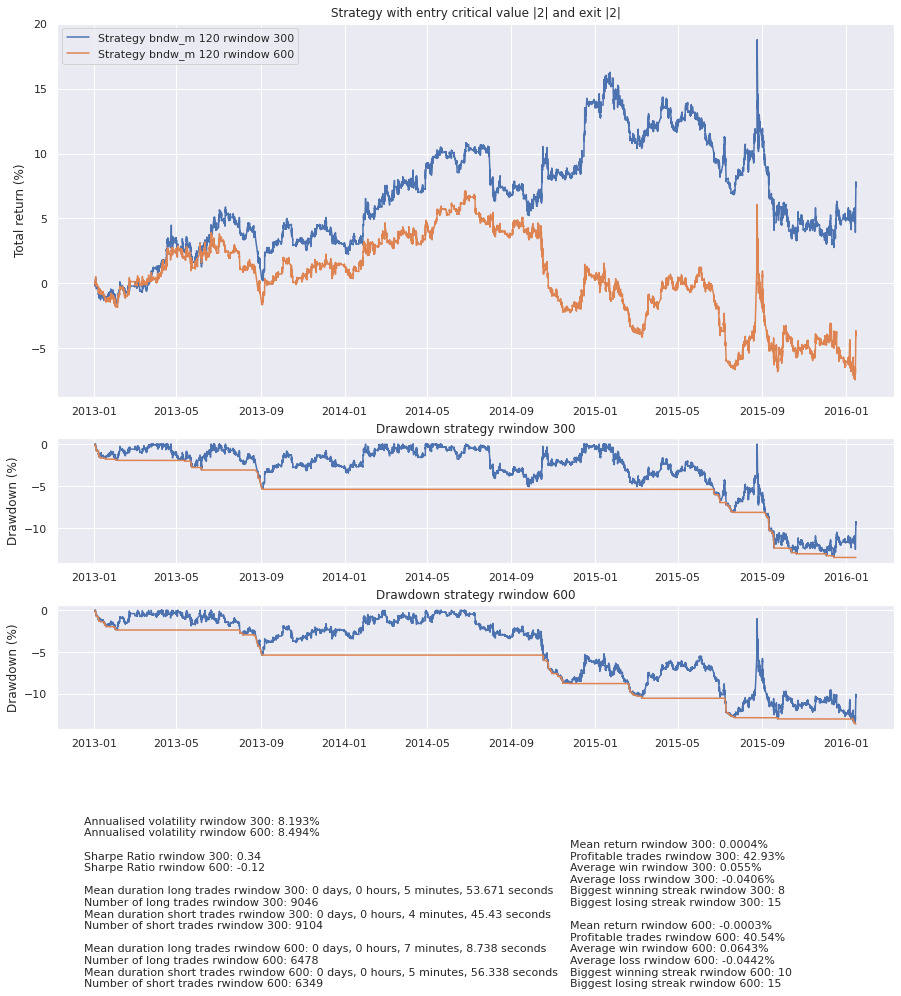

In [63]:
f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(15,13), facecolor='white')

a0.plot(Signal.t, (Signal['strat_{}_ret'.format(bndw_v1)].cumprod() - 1)*100)
a0.plot(Signal.t, (Signal['strat_{}_ret'.format(bndw_v2)].cumprod() - 1)*100)
#((Signal.Price / Signal.Price.iloc[0]).pct_change() + 1).cumprod().plot(figsize=(12,10))
a0.legend(['Strategy bndw_m {} rwindow {}'.format(bndw_m, bndw_v1), 'Strategy bndw_m {} rwindow {}'.format(bndw_m, bndw_v2)])
a0.set_title('Strategy with entry critical value |{}| and exit |{}|'.format(entry, exit))
a0.set_ylabel('Total return (%)')

text = "Annualised volatility rwindow {}: {}%\n\
Annualised volatility rwindow {}: {}%\n\n\
Sharpe Ratio rwindow {}: {}\n\
Sharpe Ratio rwindow {}: {}\n\n\
Mean duration long trades rwindow {}: {}\n\
Number of long trades rwindow {}: {}\n\
Mean duration short trades rwindow {}: {}\n\
Number of short trades rwindow {}: {}\n\n\
Mean duration long trades rwindow {}: {}\n\
Number of long trades rwindow {}: {}\n\
Mean duration short trades rwindow {}: {}\n\
Number of short trades rwindow {}: {}".format(bndw_v1, round(strat_bndw1_annualised_vol, 5)*100,
                                              bndw_v2, round(strat_bndw2_annualised_vol, 5)*100,
                                              bndw_v1, round(sharpe_bndwv1, 2), 
                                              bndw_v2, round(sharpe_bndwv2, 2),
                                              bndw_v1, str_mean_dur_long_bndwv1,
                                              bndw_v1, len(long_bndwv1_entry),
                                              bndw_v1, str_mean_dur_short_bndwv1,
                                              bndw_v1, len(short_bndwv1_entry),
                                              bndw_v2, str_mean_dur_long_bndwv2,
                                              bndw_v2, len(long_bndwv2_entry),
                                              bndw_v2, str_mean_dur_short_bndwv2,
                                              bndw_v2, len(short_bndwv2_entry))

plt.figtext(0.15, -0.15, text, fontsize=11, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

a1.set_title('Drawdown strategy rwindow {}'.format(bndw_v1))
a1.set_ylabel('Drawdown (%)')
a1.plot(Signal.t, Daily_Drawdown_bndwv1*100)
a1.plot(Signal.t, Max_Daily_Drawdown_bndwv1*100)

a2.set_title('Drawdown strategy rwindow {}'.format(bndw_v2))
a2.set_ylabel('Drawdown (%)')
a2.plot(Signal.t, Daily_Drawdown_bndwv2*100)
a2.plot(Signal.t, Max_Daily_Drawdown_bndwv2*100)

text2 = "Mean return rwindow {}: {}%\n\
Profitable trades rwindow {}: {}%\n\
Average win rwindow {}: {}%\n\
Average loss rwindow {}: {}%\n\
Biggest winning streak rwindow {}: {}\n\
Biggest losing streak rwindow {}: {}\n\n\
Mean return rwindow {}: {}%\n\
Profitable trades rwindow {}: {}%\n\
Average win rwindow {}: {}%\n\
Average loss rwindow {}: {}%\n\
Biggest winning streak rwindow {}: {}\n\
Biggest losing streak rwindow {}: {}".format(bndw_v1, round(avg_ret_bndwv1, 4),
                                             bndw_v1, round(profitable_trades_bndwv1, 2),
                                             bndw_v1, round(avg_win_bndwv1, 4),
                                             bndw_v1, round(avg_loss_bndwv1, 4),
                                             bndw_v1, max_win_streak_bndwv1,
                                             bndw_v1, max_lose_streak_bndwv1,
                                             bndw_v2, round(avg_ret_bndwv2, 4),
                                             bndw_v2, round(profitable_trades_bndwv2, 2),
                                             bndw_v2, round(avg_win_bndwv2, 4),
                                             bndw_v2, round(avg_loss_bndwv2, 4),
                                             bndw_v2, max_win_streak_bndwv2,
                                             bndw_v2, max_lose_streak_bndwv2)

plt.figtext(0.6, -0.15, text2, fontsize=11, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
plt.savefig('2min_exh_entry2_exit2')

In [22]:
max_dur_long_bndwv1 = np.max(long_bndwv1_rebased_durations)
min_dur_long_bndwv1 = np.min(long_bndwv1_rebased_durations)
max_dur_short_bndwv1 = np.max(short_bndwv1_rebased_durations)
min_dur_short_bndwv1 = np.min(short_bndwv1_rebased_durations)

days_max_long = int(max_dur_long_bndwv1)
hours_max_long = (max_dur_long_bndwv1 - days_max_long)*6.5
min_max_long = (hours_max_long - int(hours_max_long))*60
sec_max_long = (min_max_long - int(min_max_long))*60

max_long_duration = '{} days, {} hours, {} minutes, {} seconds'.format(days_max_long, int(hours_max_long), int(min_max_long), round(sec_max_long, 3))

days_min_long = int(min_dur_long_bndwv1)
hours_min_long = (min_dur_long_bndwv1 - days_min_long)*6.5
min_min_long = (hours_min_long - int(hours_min_long))*60
sec_min_long = (min_min_long - int(min_min_long))*60

min_long_duration = '{} days, {} hours, {} minutes, {} seconds'.format(days_min_long, int(hours_min_long), int(min_min_long), round(sec_min_long, 3))

days_max_short = int(max_dur_short_bndwv1)
hours_max_short = (max_dur_short_bndwv1 - days_max_short)*6.5
min_max_short = (hours_max_short - int(hours_max_short))*60
sec_max_short = (min_max_short - int(min_max_short))*60

max_short_duration = '{} days, {} hours, {} minutes, {} seconds'.format(days_max_short, int(hours_max_short), int(min_max_short), round(sec_max_short, 3))

days_min_short = int(min_dur_short_bndwv1)
hours_min_short = (min_dur_short_bndwv1 - days_min_short)*6.5
min_min_short = (hours_min_short - int(hours_min_short))*60
sec_min_short = (min_min_short - int(min_min_short))*60

min_short_duration = '{} days, {} hours, {} minutes, {} seconds'.format(days_min_short, int(hours_min_short), int(min_min_short), round(sec_min_short, 3))

print(max_short_duration)
print(min_short_duration)

1 days, 3 hours, 1 minutes, 33.561 seconds
0 days, 0 hours, 0 minutes, 17.851 seconds


In [23]:
strat_ret_bndwv1_close

array([0.99898074, 0.99911197, 1.00363593, ..., 1.0003695 , 1.0001172 ,
       1.00063901])

Text(0.6, -0.05, 'Mean return rwindow 300: 0.0004%\nProfitable trades rwindow 300: 42.93%\nAverage win rwindow 300: 0.055%\nAverage loss rwindow 300: -0.0406%\nBiggest winning streak rwindow 300: 8\nBiggest losing streak rwindow 300: 15')

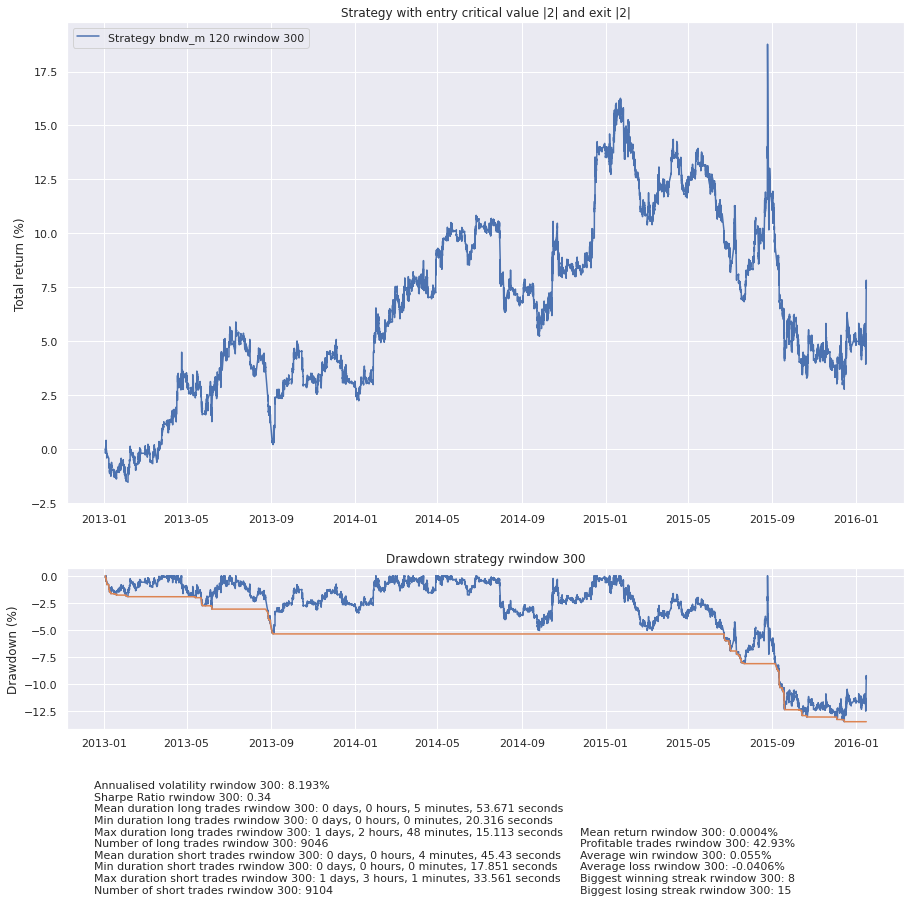

In [24]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(15,13), facecolor='white')

a0.plot(Signal.t, (Signal['strat_{}_ret'.format(bndw_v1)].cumprod() - 1)*100)

#((Signal.Price / Signal.Price.iloc[0]).pct_change() + 1).cumprod().plot(figsize=(12,10))
a0.legend(['Strategy bndw_m {} rwindow {}'.format(bndw_m, bndw_v1)])
a0.set_title('Strategy with entry critical value |{}| and exit |{}|'.format(entry, exit))
a0.set_ylabel('Total return (%)')

text = "Annualised volatility rwindow {}: {}%\n\
Sharpe Ratio rwindow {}: {}\n\
Mean duration long trades rwindow {}: {}\n\
Min duration long trades rwindow {}: {}\n\
Max duration long trades rwindow {}: {}\n\
Number of long trades rwindow {}: {}\n\
Mean duration short trades rwindow {}: {}\n\
Min duration short trades rwindow {}: {}\n\
Max duration short trades rwindow {}: {}\n\
Number of short trades rwindow {}: {}".format(bndw_v1, round(strat_bndw1_annualised_vol, 5)*100,
                                              bndw_v1, round(sharpe_bndwv1, 2), 
                                              bndw_v1, str_mean_dur_long_bndwv1,
                                              bndw_v1, min_long_duration,
                                              bndw_v1, max_long_duration,
                                              bndw_v1, len(long_bndwv1_entry),
                                              bndw_v1, str_mean_dur_short_bndwv1,
                                              bndw_v1, min_short_duration,
                                              bndw_v1, max_short_duration,
                                              bndw_v1, len(short_bndwv1_entry))

plt.figtext(0.15, -0.05, text, fontsize=11, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

a1.set_title('Drawdown strategy rwindow {}'.format(bndw_v1))
a1.set_ylabel('Drawdown (%)')
a1.plot(Signal.t, Daily_Drawdown_bndwv1*100)
a1.plot(Signal.t, Max_Daily_Drawdown_bndwv1*100)

text2 = "Mean return rwindow {}: {}%\n\
Profitable trades rwindow {}: {}%\n\
Average win rwindow {}: {}%\n\
Average loss rwindow {}: {}%\n\
Biggest winning streak rwindow {}: {}\n\
Biggest losing streak rwindow {}: {}".format(bndw_v1, round(avg_ret_bndwv1, 4),
                                            bndw_v1, round(profitable_trades_bndwv1, 2),
                                            bndw_v1, round(avg_win_bndwv1, 4),
                                            bndw_v1, round(avg_loss_bndwv1, 4),
                                            bndw_v1, max_win_streak_bndwv1,
                                            bndw_v1, max_lose_streak_bndwv1)

plt.figtext(0.6, -0.05, text2, fontsize=11, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

In [25]:
skew = daily_ret_bndwv1.skew()
kurt = daily_ret_bndwv1.kurt()

/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.33, 0.83, 'Daily returns skewness: 2.05\nDaily returns kurtosis: 39.48')

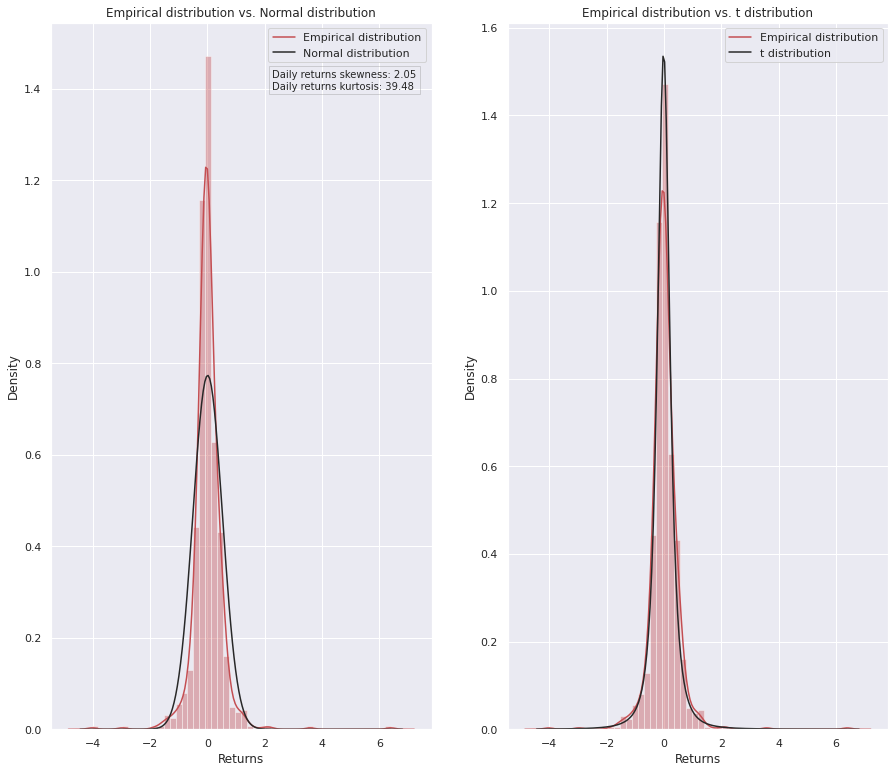

In [26]:
from scipy import stats
from scipy.stats import norm
from scipy.stats import t

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(15,13), facecolor='white')

sns.distplot((daily_ret_bndwv1 - 1)*100, kde=True, color='r', fit=norm, kde_kws={'bw_adjust': 1.2, 'cut': 5}, ax=a0)
sns.distplot((daily_ret_bndwv1 - 1)*100, kde=True, color='r', fit=t, kde_kws={'bw_adjust': 1.2, 'cut': 5}, ax=a1)
a0.set_title('Empirical distribution vs. Normal distribution')
a0.set_xlabel('Returns')
a0.legend(['Empirical distribution', 'Normal distribution'])
a1.set_title('Empirical distribution vs. t distribution')
a1.set_xlabel('Returns')
a1.legend(['Empirical distribution', 't distribution'])

text = "Daily returns skewness: {}\n\
Daily returns kurtosis: {}".format(round(skew, 2), round(kurt, 2))
                                   
props = dict(boxstyle='square', facecolor='none', edgecolor='grey', alpha=0.3)

f.text(0.33, 0.83, text, fontsize=10,
       verticalalignment='top', bbox=props)

Text(0.5, 0, 'Returns')

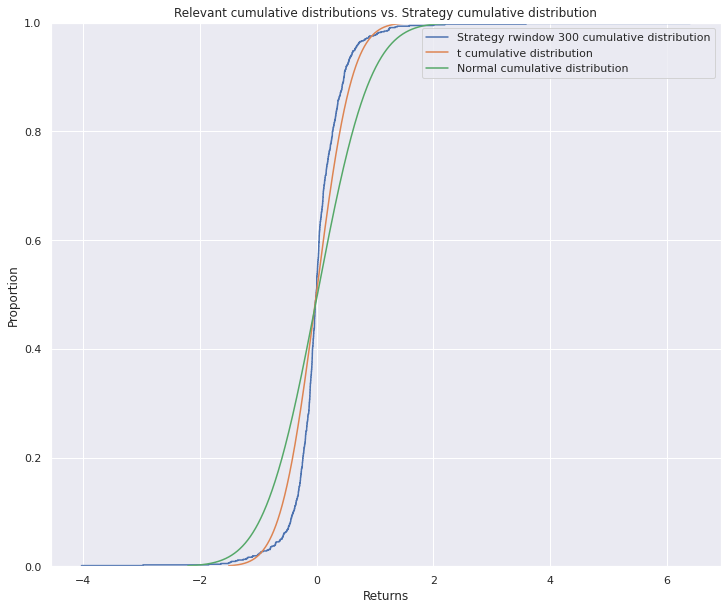

In [27]:
sns.ecdfplot((daily_ret_bndwv1 - 1)*100)

mean_norm, var_norm = stats.norm.fit((daily_ret_bndwv1 - 1)*100)
std_norm = np.sqrt(var_norm)
df_t, mean_t, var_t = stats.t.fit((daily_ret_bndwv1 - 1)*100)
std_t = np.sqrt(var_t)

rv1 = t(df=251, loc=mean_t, scale=std_t)
x1 = np.linspace(rv1.ppf(0.001), rv1.ppf(0.999), 1000)
y1 = rv1.cdf(x1)
plt.plot(x1, y1)

rv2 = norm(loc=mean_norm, scale=std_norm)
x2 = np.linspace(rv2.ppf(0.001), rv2.ppf(0.999), 1000)
y2 = rv2.cdf(x2)
plt.plot(x2, y2)

plt.title('Relevant cumulative distributions vs. Strategy cumulative distribution')
plt.legend(['Strategy rwindow {} cumulative distribution'.format(bndw_v1), 't cumulative distribution', 'Normal cumulative distribution', 'Cauchy cumulative distribution'])
plt.xlabel('Returns')

/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Absolute frequency')

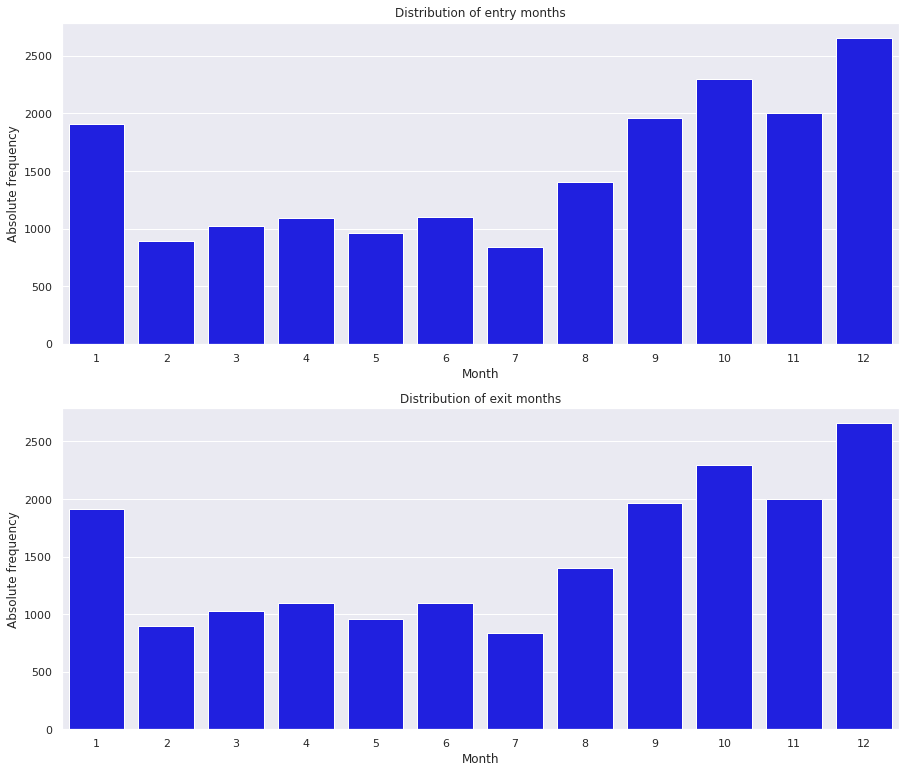

In [28]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(15,13), facecolor='white')

sns.countplot(pd.Series(strat_bndwv1_entry).dt.month, color='blue', ax=a0)
sns.countplot(pd.Series(strat_bndwv1_exit).dt.month, color='blue', ax=a1)

a0.set_title('Distribution of entry months')
a0.set_xlabel('Month')
a0.set_ylabel('Absolute frequency')

a1.set_title('Distribution of exit months')
a1.set_xlabel('Month')
a1.set_ylabel('Absolute frequency')

/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Absolute frequency')

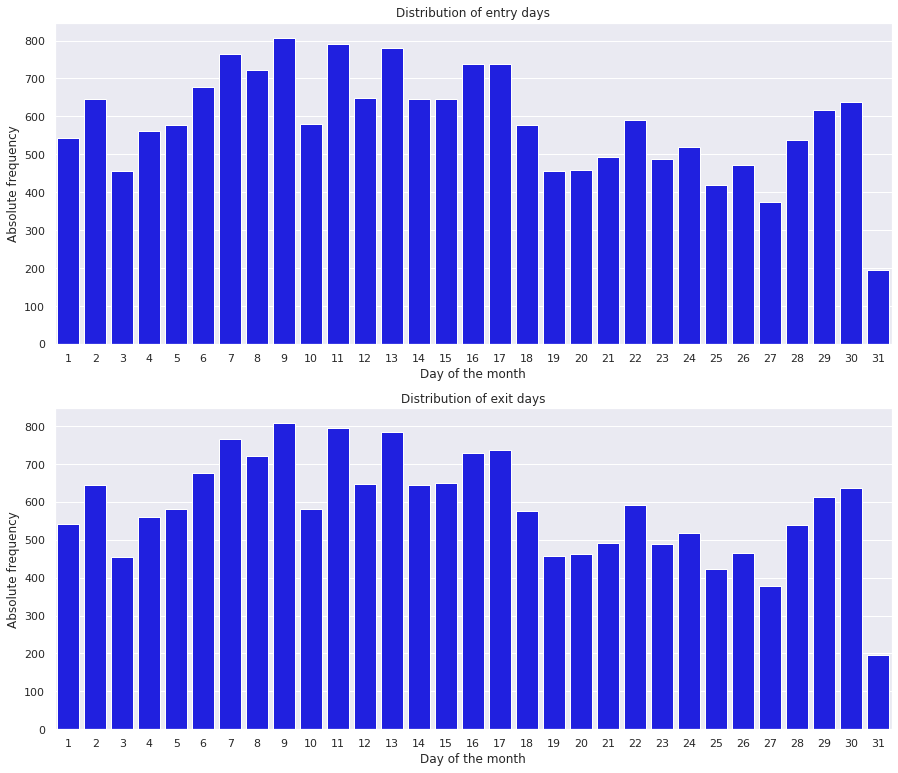

In [29]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(15,13), facecolor='white')

sns.countplot(pd.Series(strat_bndwv1_entry).dt.day, color='blue', ax=a0)
sns.countplot(pd.Series(strat_bndwv1_exit).dt.day, color='blue', ax=a1)

a0.set_title('Distribution of entry days')
a0.set_xlabel('Day of the month')
a0.set_ylabel('Absolute frequency')

a1.set_title('Distribution of exit days')
a1.set_xlabel('Day of the month')
a1.set_ylabel('Absolute frequency')


/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Absolute frequency')

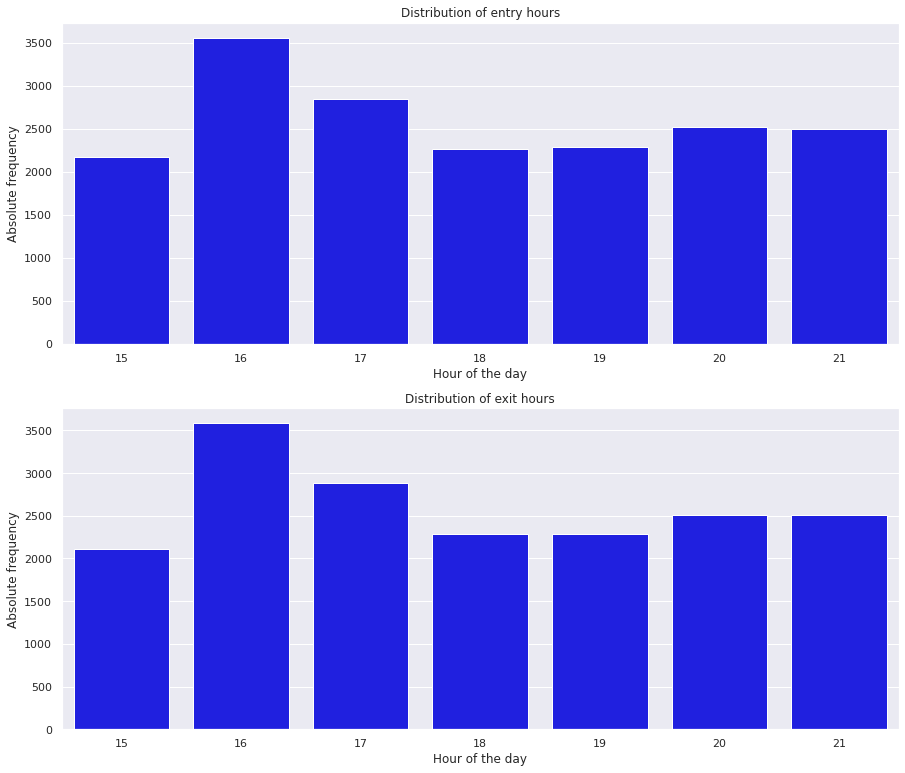

In [30]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(15,13), facecolor='white')

sns.countplot(pd.Series(strat_bndwv1_entry).dt.hour, color='blue', ax=a0)
sns.countplot(pd.Series(strat_bndwv1_exit).dt.hour, color='blue', ax=a1)

a0.set_title('Distribution of entry hours')
a0.set_xlabel('Hour of the day')
a0.set_ylabel('Absolute frequency')

a1.set_title('Distribution of exit hours')
a1.set_xlabel('Hour of the day')
a1.set_ylabel('Absolute frequency')

/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Absolute frequency')

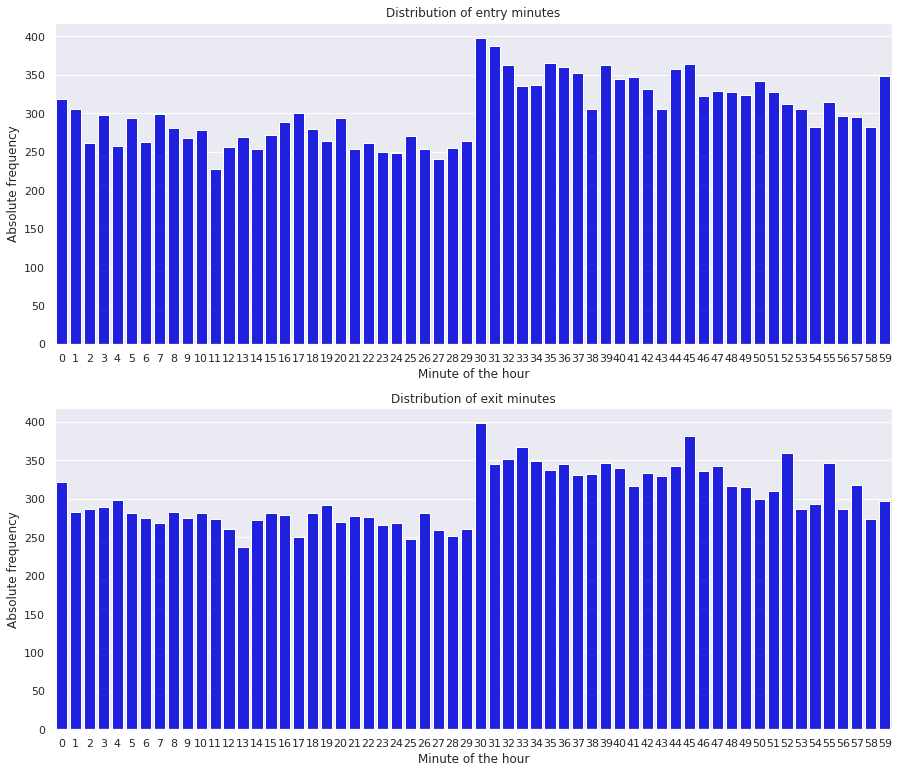

In [31]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(15,13), facecolor='white')

sns.countplot(pd.Series(strat_bndwv1_entry).dt.minute, color='blue', ax=a0)
sns.countplot(pd.Series(strat_bndwv1_exit).dt.minute, color='blue', ax=a1)

a0.set_title('Distribution of entry minutes')
a0.set_xlabel('Minute of the hour')
a0.set_ylabel('Absolute frequency')

a1.set_title('Distribution of exit minutes')
a1.set_xlabel('Minute of the hour')
a1.set_ylabel('Absolute frequency')

Text(0.5, 0, 'Log-durations of trades in seconds')

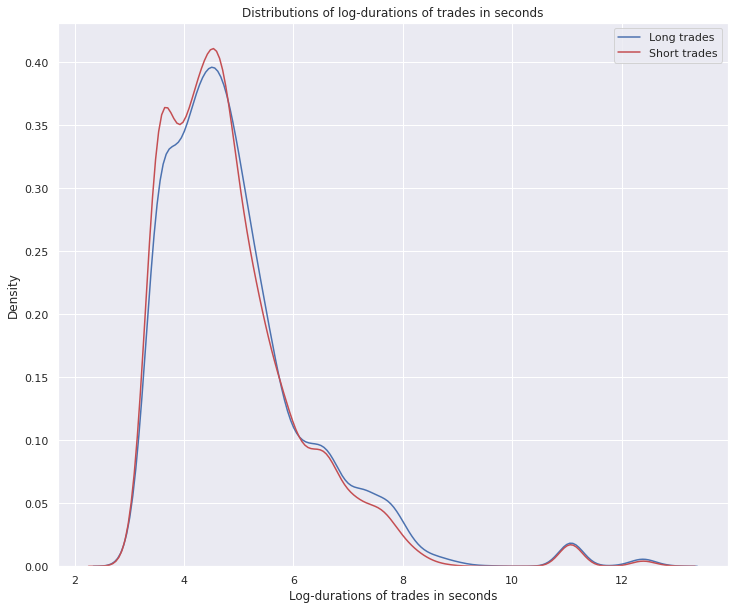

In [32]:
sns.kdeplot(np.log(pd.Series(durations_long_bndwv1).dt.total_seconds()))
sns.kdeplot(np.log(pd.Series(durations_short_bndwv1).dt.total_seconds()), color='r')

plt.title('Distributions of log-durations of trades in seconds')
plt.legend(['Long trades', 'Short trades'])
plt.xlabel('Log-durations of trades in seconds')

Text(0.5, 0, 'Log-durations of trades in seconds')

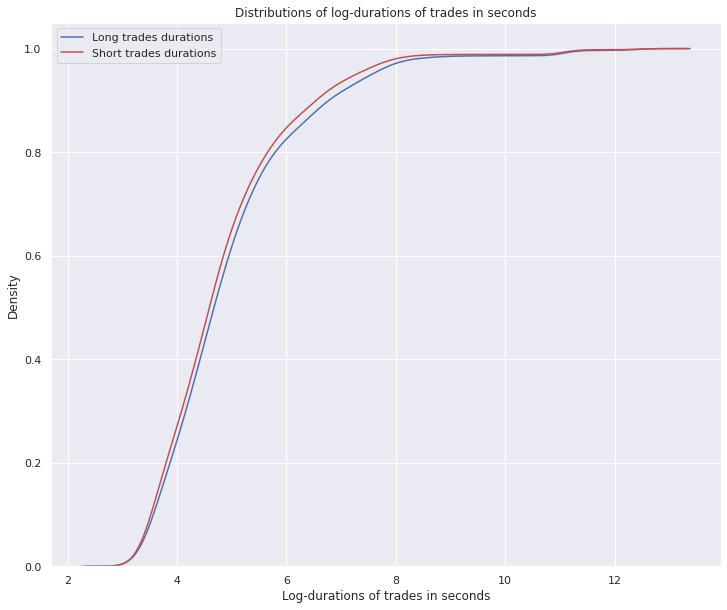

In [33]:
sns.kdeplot(np.log(pd.Series(durations_long_bndwv1).dt.total_seconds()), cumulative=True)
sns.kdeplot(np.log(pd.Series(durations_short_bndwv1).dt.total_seconds()), color='r', cumulative=True)

plt.title('Distributions of log-durations of trades in seconds')
plt.legend(['Long trades durations', 'Short trades durations'])
plt.xlabel('Log-durations of trades in seconds')

# Statistics

In [34]:
crit_norm_95 = stats.norm.ppf(0.05)
crit_norm_99 = stats.norm.ppf(0.01)
crit_norm_999 = stats.norm.ppf(0.001)
crit_t_95 = stats.t.ppf(0.05, df=251)
crit_t_99 = stats.t.ppf(0.01, df=251)
crit_t_999 = stats.t.ppf(0.001, df=251)

In [35]:
# 1-day risk measures
mean_norm, var_norm = stats.norm.fit(daily_ret_bndwv1 - 1)
std_norm = np.sqrt(var_norm)
df_t, mean_t, var_t = stats.t.fit(daily_ret_bndwv1 - 1)
std_t = np.sqrt(var_t)

#VaR

ordered_daily_ret = np.sort(daily_ret_bndwv1 - 1)
hist_var_1_day_95 = np.quantile(ordered_daily_ret, 0.05)
hist_var_1_day_99 = np.quantile(ordered_daily_ret, 0.01)
hist_var_1_day_999 = np.quantile(ordered_daily_ret, 0.001)

t_var_1_day_95 = mean_t + std_t/np.sqrt(252)*crit_t_95
t_var_1_day_99 = mean_t + std_t/np.sqrt(252)*crit_t_99
t_var_1_day_999 = mean_t + std_t/np.sqrt(252)*crit_t_999

normal_var_1_day_95 = mean_norm + std_norm/np.sqrt(252)*crit_norm_95
normal_var_1_day_99 = mean_norm + std_norm/np.sqrt(252)*crit_norm_99
normal_var_1_day_999 = mean_norm + std_norm/np.sqrt(252)*crit_norm_999

#Expected shortfall
hist_es_1_day_95 = np.mean(ordered_daily_ret[ordered_daily_ret < hist_var_1_day_95])
hist_es_1_day_99 = np.mean(ordered_daily_ret[ordered_daily_ret < hist_var_1_day_99])
hist_es_1_day_999 = np.mean(ordered_daily_ret[ordered_daily_ret < hist_var_1_day_999])

t_es_1_day_95 = mean_t + std_t/np.sqrt(252) * -(t.pdf(t.ppf(0.05, 251), 251))/0.05
t_es_1_day_99 = mean_t + std_t/np.sqrt(252) * -(t.pdf(t.ppf(0.01, 251), 251))/0.01
t_es_1_day_999 = mean_t + std_t/np.sqrt(252) * -(t.pdf(t.ppf(0.001, 251), 251))/0.001

normal_es_1_day_95 = mean_norm + std_norm/np.sqrt(252) * -(norm.pdf(norm.ppf(0.05)))/0.05
normal_es_1_day_99 = mean_norm + std_norm/np.sqrt(252) * -(norm.pdf(norm.ppf(0.01)))/0.01
normal_es_1_day_999 = mean_norm + std_norm/np.sqrt(252) * -(norm.pdf(norm.ppf(0.001)))/0.001

In [36]:
crit_t_95 = stats.t.ppf(0.05, df=246)
crit_t_99 = stats.t.ppf(0.01, df=246)
crit_t_999 = stats.t.ppf(0.001, df=246)

In [37]:
# 1-week VaR
weekly_ret = pd.Series(daily_ret_bndwv1).rolling(window=5).apply(np.prod).dropna().values
ordered_weekly_ret = np.sort(weekly_ret - 1)

mean_norm, var_norm = stats.norm.fit(weekly_ret - 1)
std_norm = np.sqrt(var_norm)
df_t, mean_t, var_t = stats.t.fit(weekly_ret - 1)
std_t = np.sqrt(var_t)

hist_var_1_week_95 = np.quantile(ordered_weekly_ret, 0.05)
hist_var_1_week_99 = np.quantile(ordered_weekly_ret, 0.01)
hist_var_1_week_999 = np.quantile(ordered_weekly_ret, 0.001)

t_var_1_week_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(5)*crit_t_95
t_var_1_week_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(5)*crit_t_99
t_var_1_week_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(5)*crit_t_999

normal_var_1_week_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5)*crit_norm_95
normal_var_1_week_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5)*crit_norm_99
normal_var_1_week_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5)*crit_norm_999

#Expected shortfall
hist_es_1_week_95 = np.mean(ordered_weekly_ret[ordered_weekly_ret < hist_var_1_week_95])
hist_es_1_week_99 = np.mean(ordered_weekly_ret[ordered_weekly_ret < hist_var_1_week_99])
hist_es_1_week_999 = np.mean(ordered_weekly_ret[ordered_weekly_ret < hist_var_1_week_999])

t_es_1_week_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(5) * -(t.pdf(t.ppf(0.05, 246), 246))/0.05
t_es_1_week_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(5) * -(t.pdf(t.ppf(0.01, 246), 246))/0.01
t_es_1_week_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(5) * -(t.pdf(t.ppf(0.001, 246), 246))/0.001

normal_es_1_week_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5) * -(norm.pdf(norm.ppf(0.05)))/0.05
normal_es_1_week_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5) * -(norm.pdf(norm.ppf(0.01)))/0.01
normal_es_1_week_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(5) * -(norm.pdf(norm.ppf(0.001)))/0.001

In [38]:
crit_t_95 = stats.t.ppf(0.05, df=241)
crit_t_99 = stats.t.ppf(0.01, df=241)
crit_t_999 = stats.t.ppf(0.001, df=241)

In [39]:
# 10-days VaR
ten_days_ret = pd.Series(daily_ret_bndwv1).rolling(window=10).apply(np.prod).dropna().values
ordered_10_days_ret = np.sort(ten_days_ret - 1)

mean_norm, var_norm = stats.norm.fit(ten_days_ret - 1)
std_norm = np.sqrt(var_norm)
df_t, mean_t, var_t = stats.t.fit(ten_days_ret - 1)
std_t = np.sqrt(var_t)

hist_var_10_days_95 = np.quantile(ordered_10_days_ret, 0.05)
hist_var_10_days_99 = np.quantile(ordered_10_days_ret, 0.01)
hist_var_10_days_999 = np.quantile(ordered_10_days_ret, 0.001)

t_var_10_days_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(10)*crit_t_95
t_var_10_days_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(10)*crit_t_99
t_var_10_days_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(10)*crit_t_999

normal_var_10_days_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10)*crit_norm_95
normal_var_10_days_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10)*crit_norm_99
normal_var_10_days_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10)*crit_norm_999

#Expected shortfall
hist_es_10_days_95 = np.mean(ordered_10_days_ret[ordered_10_days_ret < hist_var_10_days_95])
hist_es_10_days_99 = np.mean(ordered_10_days_ret[ordered_10_days_ret < hist_var_10_days_99])
hist_es_10_days_999 = np.mean(ordered_10_days_ret[ordered_10_days_ret < hist_var_10_days_999])

t_es_10_days_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(10) * -(t.pdf(t.ppf(0.05, 241), 241))/0.05
t_es_10_days_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(10) * -(t.pdf(t.ppf(0.01, 241), 241))/0.01
t_es_10_days_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(10) * -(t.pdf(t.ppf(0.001, 241), 241))/0.001

normal_es_10_days_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10) * -(norm.pdf(norm.ppf(0.05)))/0.05
normal_es_10_days_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10) * -(norm.pdf(norm.ppf(0.01)))/0.01
normal_es_10_days_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(10) * -(norm.pdf(norm.ppf(0.001)))/0.001

In [40]:
crit_t_95 = stats.t.ppf(0.05, df=230)
crit_t_99 = stats.t.ppf(0.01, df=230)
crit_t_999 = stats.t.ppf(0.001, df=230)

In [41]:
# 1-month VaR
monthly_ret = pd.Series(daily_ret_bndwv1).rolling(window=21).apply(np.prod).dropna().values
ordered_monthly_ret = np.sort(monthly_ret - 1)

mean_norm, var_norm = stats.norm.fit(monthly_ret - 1)
std_norm = np.sqrt(var_norm)
df_t, mean_t, var_t = stats.t.fit(monthly_ret - 1)
std_t = np.sqrt(var_t)

hist_var_1_month_95 = np.quantile(ordered_monthly_ret, 0.05)
hist_var_1_month_99 = np.quantile(ordered_monthly_ret, 0.01)
hist_var_1_month_999 = np.quantile(ordered_monthly_ret, 0.001)

t_var_1_month_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(21)*crit_t_95
t_var_1_month_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(21)*crit_t_99
t_var_1_month_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(21)*crit_t_999

normal_var_1_month_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21)*crit_norm_95
normal_var_1_month_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21)*crit_norm_99
normal_var_1_month_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21)*crit_norm_999

#Expected shortfall
hist_es_1_month_95 = np.mean(ordered_monthly_ret[ordered_monthly_ret < hist_var_1_month_95])
hist_es_1_month_99 = np.mean(ordered_monthly_ret[ordered_monthly_ret < hist_var_1_month_99])
hist_es_1_month_999 = np.mean(ordered_monthly_ret[ordered_monthly_ret < hist_var_1_month_999])

t_es_1_month_95 = mean_t + std_t/np.sqrt(252)*np.sqrt(21) * -(t.pdf(t.ppf(0.05, 230), 230))/0.05
t_es_1_month_99 = mean_t + std_t/np.sqrt(252)*np.sqrt(21) * -(t.pdf(t.ppf(0.01, 230), 230))/0.01
t_es_1_month_999 = mean_t + std_t/np.sqrt(252)*np.sqrt(21) * -(t.pdf(t.ppf(0.001, 230), 230))/0.001

normal_es_1_month_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21) * -(norm.pdf(norm.ppf(0.05)))/0.05
normal_es_1_month_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21) * -(norm.pdf(norm.ppf(0.01)))/0.01
normal_es_1_month_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(21) * -(norm.pdf(norm.ppf(0.001)))/0.001

In [42]:
# VaR-ES table
day_1_risk = pd.Series([hist_var_1_day_95, hist_var_1_day_99, hist_var_1_day_999,
                        hist_es_1_day_95, hist_es_1_day_99, hist_es_1_day_999,
                        t_var_1_day_95, t_var_1_day_99, t_var_1_day_999,
                        t_es_1_day_95, t_es_1_day_99, t_es_1_day_999,
                        normal_var_1_day_95, normal_var_1_day_99, normal_var_1_day_999,
                        normal_es_1_day_95, normal_es_1_day_99, normal_es_1_day_999])

week_1_risk = pd.Series([hist_var_1_week_95, hist_var_1_week_99, hist_var_1_week_999,
                         hist_es_1_week_95, hist_es_1_week_99, hist_es_1_week_999,
                         t_var_1_week_95, t_var_1_week_99, t_var_1_week_999,
                         t_es_1_week_95, t_es_1_week_99, t_es_1_week_999,
                         normal_var_1_week_95, normal_var_1_week_99, normal_var_1_week_999,
                         normal_es_1_week_95, normal_es_1_week_99, normal_es_1_week_999])

days_10_risk = pd.Series([hist_var_10_days_95, hist_var_10_days_99, hist_var_10_days_999,
                          hist_es_10_days_95, hist_es_10_days_99, hist_es_10_days_999,
                          t_var_10_days_95, t_var_10_days_99, t_var_10_days_999,
                          t_es_10_days_95, t_es_10_days_99, t_es_10_days_999,
                          normal_var_10_days_95, normal_var_10_days_99, normal_var_10_days_999,
                          normal_es_10_days_95, normal_es_10_days_99, normal_es_10_days_999])

month_1_risk = pd.Series([hist_var_1_month_95, hist_var_1_month_99, hist_var_1_month_999,
                          hist_es_1_month_95, hist_es_1_month_99, hist_es_1_month_999,
                          t_var_1_month_95, t_var_1_month_99, t_var_1_month_999,
                          t_es_1_month_95, t_es_1_month_99, t_es_1_month_999,
                          normal_var_1_month_95, normal_var_1_month_99, normal_var_1_month_999,
                          normal_es_1_month_95, normal_es_1_month_99, normal_es_1_month_999])

columns = ['1 Day', '1 Week', '10 Days', '1 Month']

index = pd.MultiIndex.from_product([['hVaR', 'hES', 't-VaR', 't-ES', 'Normal VaR', 'Normal ES'], ['95%', '99%', '99.9%']], names=['Risk measure', 'Confidence'])

risks = pd.DataFrame(data=[day_1_risk, week_1_risk, days_10_risk, month_1_risk])
risks = risks.transpose()
risks.columns = columns
risks.index = index

s = risks.style
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


cm = sns.color_palette('viridis', as_cmap=True, )

risks.style.background_gradient(cmap=cm)

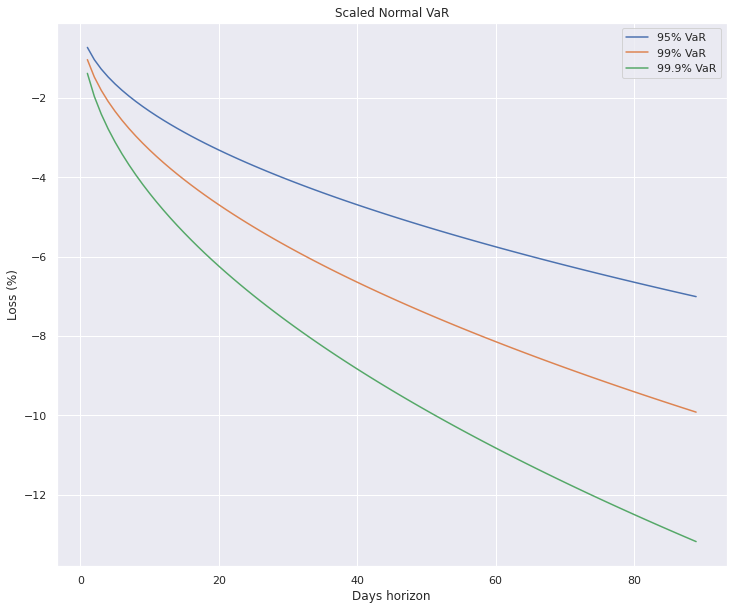

In [43]:
days = np.arange(1, 90)
mean_norm, var_norm = stats.norm.fit(daily_ret_bndwv1 - 1)
std_norm = np.sqrt(var_norm)

normal_var_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days)*crit_norm_95
normal_var_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days)*crit_norm_99
normal_var_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days)*crit_norm_999

plt.plot(days, normal_var_95*100)
plt.plot(days, normal_var_99*100)
plt.plot(days, normal_var_999*100)
plt.title('Scaled Normal VaR')
plt.ylabel('Loss (%)')
plt.xlabel('Days horizon')
plt.legend(['95% VaR', '99% VaR', '99.9% VaR'])

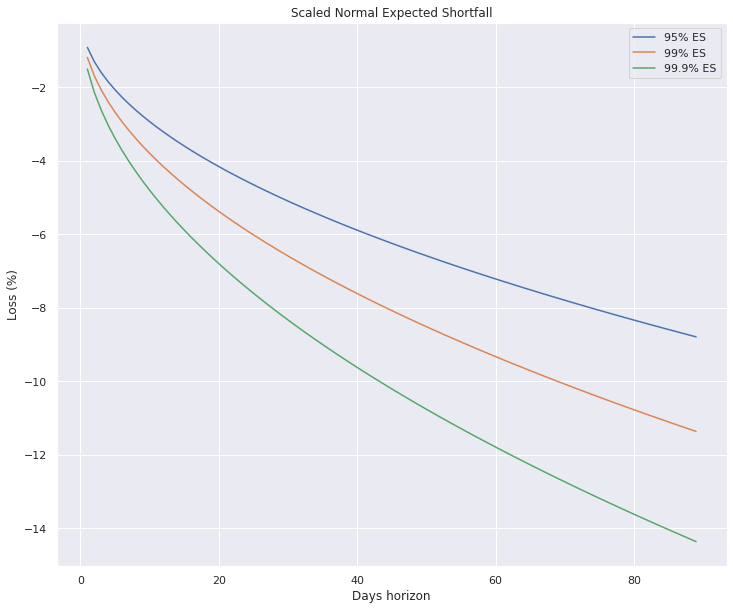

In [44]:
days = np.arange(1, 90)
normal_es_95 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days) * -(norm.pdf(norm.ppf(0.05)))/0.05
normal_es_99 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days) * -(norm.pdf(norm.ppf(0.01)))/0.01
normal_es_999 = mean_norm + std_norm/np.sqrt(252)*np.sqrt(days) * -(norm.pdf(norm.ppf(0.001)))/0.001

plt.plot(days, normal_es_95*100)
plt.plot(days, normal_es_99*100)
plt.plot(days, normal_es_999*100)
plt.title('Scaled Normal Expected Shortfall')
plt.ylabel('Loss (%)')
plt.xlabel('Days horizon')
plt.legend(['95% ES', '99% ES', '99.9% ES'])

In [45]:
Signal['money'] = Signal.ret + 1

  Using cached statsmodels-0.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)


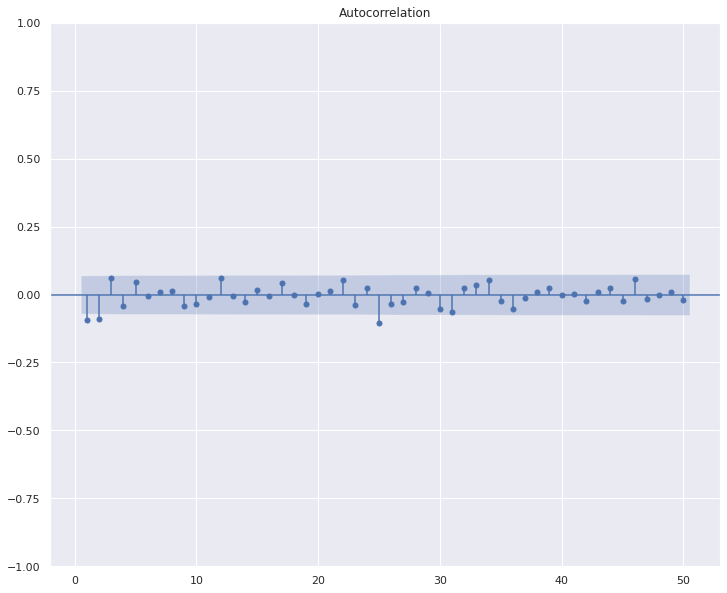

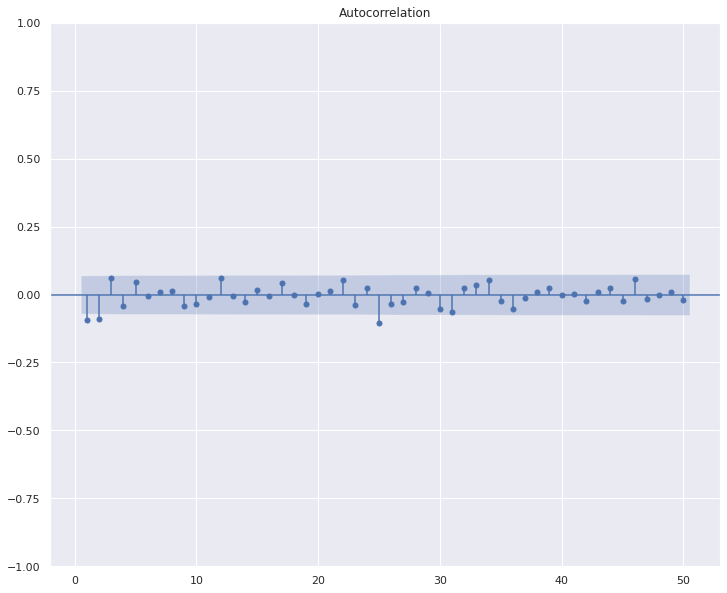

In [46]:
!pip install statsmodels
from statsmodels.graphics import tsaplots

tsaplots.plot_acf(daily_ret_bndwv1, lags=50, zero=False)

/srv/conda/envs/saturn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


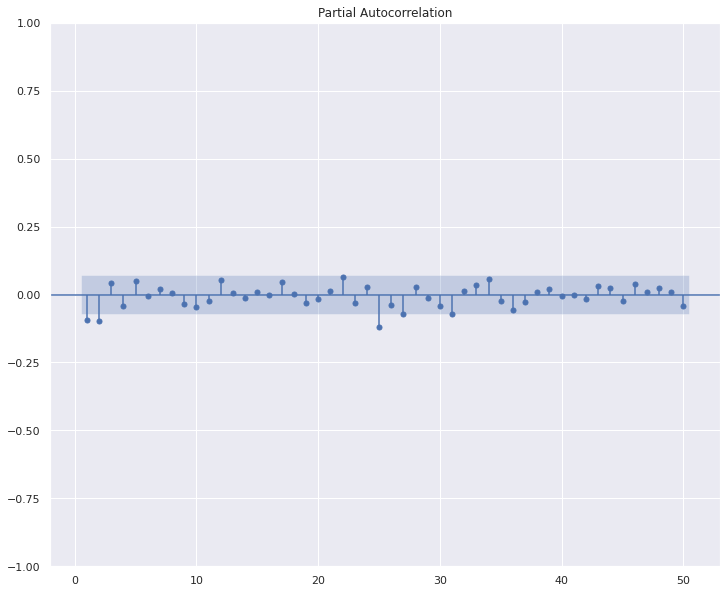

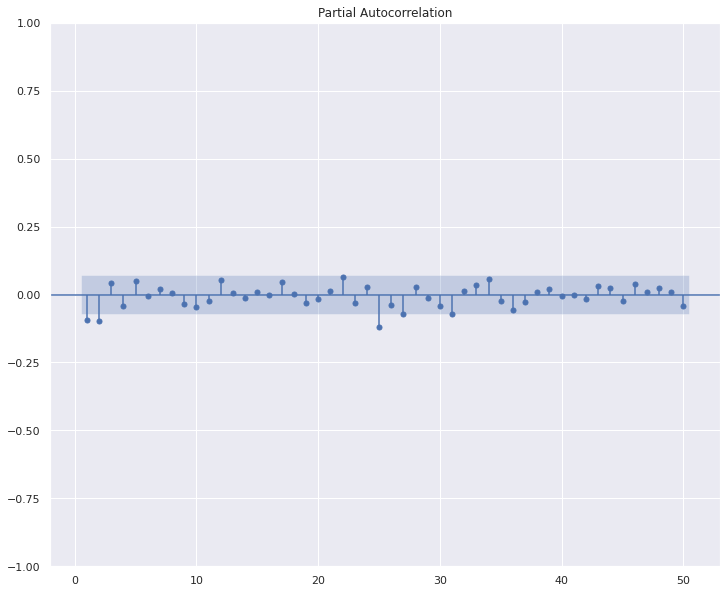

In [47]:
tsaplots.plot_pacf(daily_ret_bndwv1, lags=50, zero=False)

In [48]:
from scipy import stats

spearman_corr = stats.spearmanr(daily_ret_bndwv1, Signal.groupby('day')['money'].prod())
corr = np.corrcoef(daily_ret_bndwv1, Signal.groupby('day')['money'].prod())[0, 1]

mean_test = avg_ret_bndwv2/(np.sqrt((strat_bndw1_annualised_vol/np.sqrt(252))**2/252))
annualised_cov_strat_stock = np.cov(daily_ret_bndwv1, Signal.groupby('day')['money'].prod())[0, 1]*252
annualised_var_stock = np.var(Signal.groupby('day')['money'].prod())*252
beta = annualised_cov_strat_stock/annualised_var_stock
print('Corr:', corr)
print('Beta:', beta)

Corr: -0.08763321456628977
Beta: -0.05565089595881875


/srv/conda/envs/saturn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x936 with 0 Axes>

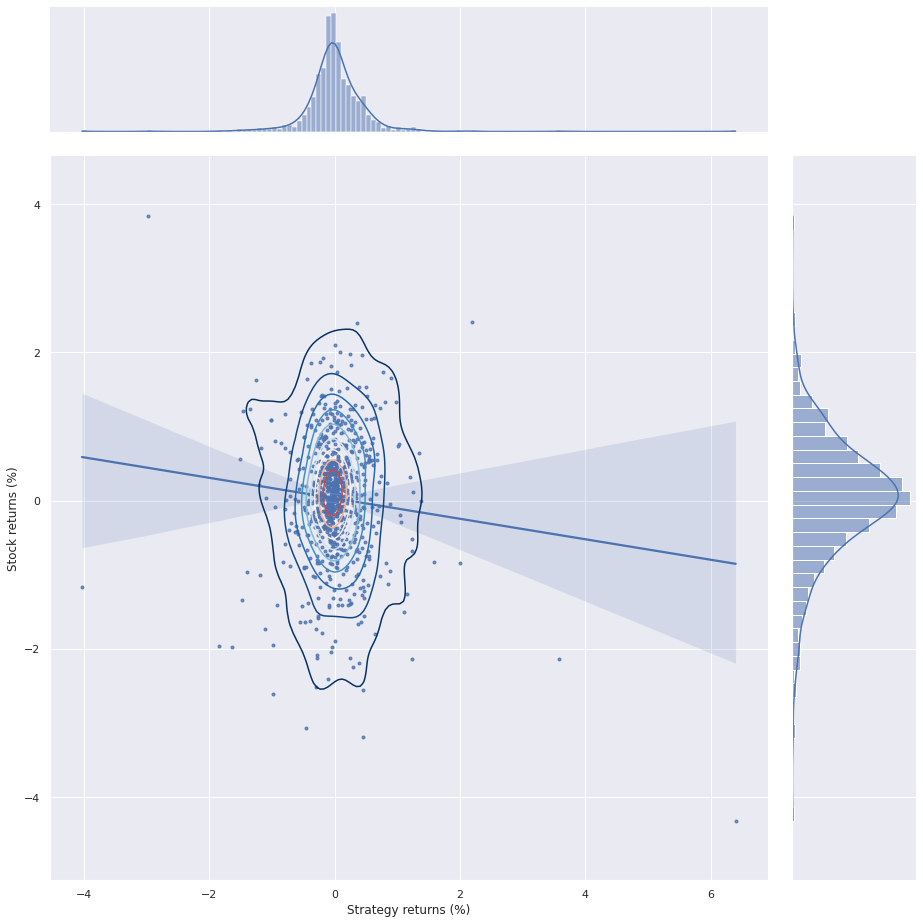

In [49]:
plt.figure(figsize=(15,13))
(sns.jointplot((daily_ret_bndwv1 - 1)*100, (Signal.groupby('day')['money'].prod() - 1)*100, marker='.', kind='reg', height=13).plot_joint(sns.kdeplot, n_levels=10, cmap="RdBu_r")).set_axis_labels('Strategy returns (%)', 'Stock returns (%)')

# Buy and hold

In [50]:
ann_ret_buy_hold = Signal.groupby('day')['money'].prod().mean() ** 252 - 1
ann_vol_buy_hold = Signal.groupby('day')['money'].prod().std()*np.sqrt(252)
sharpe_buy_hold = ann_ret_buy_hold/ann_vol_buy_hold
print('Sharpe:', sharpe_buy_hold)
print('Vol:', ann_vol_buy_hold)

Sharpe: 0.6272563182366012
Vol: 0.1291840724394683


Text(0, 0.5, 'Total return (%)')

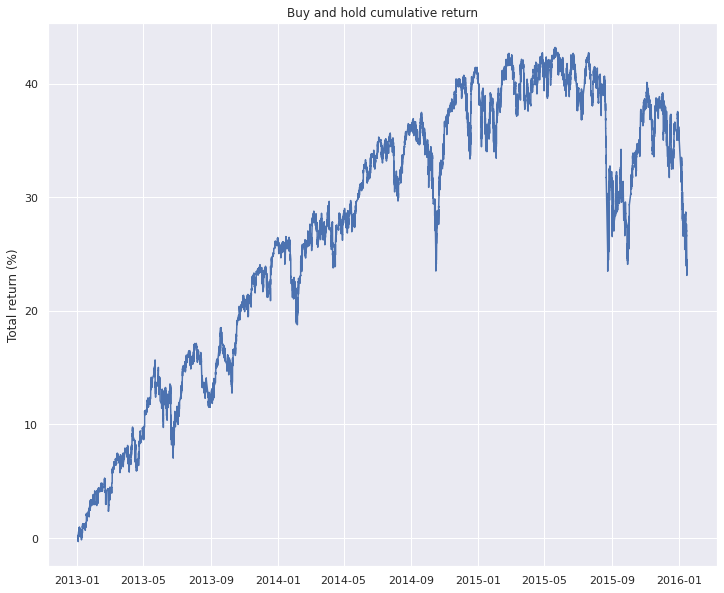

In [51]:
plt.plot(Signal.t, ((Signal.ret + 1).cumprod() - 1)*100)
plt.title('Buy and hold cumulative return')
plt.ylabel('Total return (%)')

In [52]:
!pip install pyfolio
import pyfolio as pf

  Using cached pyfolio-0.9.2-py3-none-any.whl
  Using cached empyrical-0.5.5-py3-none-any.whl
  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
  Using cached lxml-4.7.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (6.9 MB)


/srv/conda/envs/saturn/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [53]:
entries = pd.DataFrame(data=strat_bndwv1_entry, columns=['date'])
entries['pos'] = 1
entries['day'] = entries['date'].dt.date
entries = pd.DataFrame(entries.groupby('day')['pos'].sum())
entries

,pos
day,
2013-01-02,3
2013-01-03,7
2013-01-04,4
2013-01-07,6
2013-01-08,6
...,...
2016-01-11,149
2016-01-12,108
2016-01-13,163


In [54]:
daily_ret_bndwv1.index = pd.to_datetime(daily_ret_bndwv1.index)

In [55]:
Signal['ret'] = Signal.ret + 1

In [56]:
s = Signal.groupby('day')['ret'].prod() - 1
s

day
2013-01-02    0.001804
2013-01-03    0.000165
2013-01-04    0.007436
2013-01-07   -0.004482
2013-01-08   -0.003543
                ...   
2016-01-11    0.000867
2016-01-12    0.007901
2016-01-13   -0.025169
2016-01-14    0.016229
2016-01-15   -0.021373
Name: ret, Length: 779, dtype: float64

Text(0.5, 1.0, 'Rolling Sharpe ratio (1-month)')

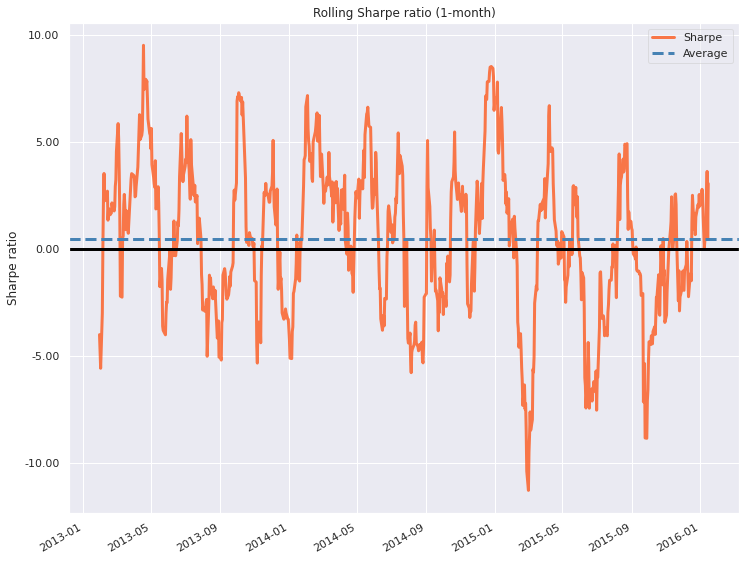

In [57]:
pf.plot_rolling_sharpe(daily_ret_bndwv1-1, rolling_window=21)
plt.title('Rolling Sharpe ratio (1-month)')

Text(0, 0.5, 'Volatility (%)')

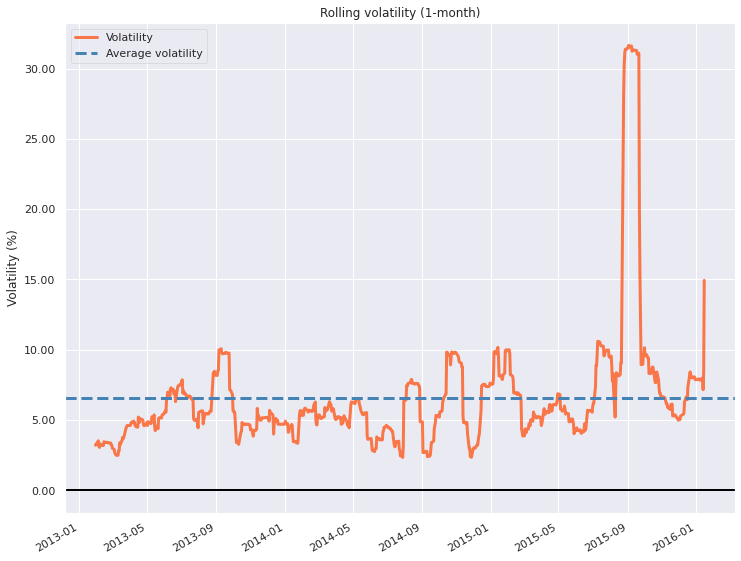

In [58]:
pf.plot_rolling_volatility((daily_ret_bndwv1-1)*100, rolling_window=21)
plt.title('Rolling volatility (1-month)')
plt.ylabel('Volatility (%)')

In [59]:
top_dd = pf.timeseries.get_top_drawdowns(daily_ret_bndwv1-1)
top_dd

[(Timestamp('2015-08-24 00:00:00'), 755, nan),
 (Timestamp('2015-01-22 00:00:00'), 650, Timestamp('2015-08-24 00:00:00')),
 (Timestamp('2013-07-02 00:00:00'), 170, Timestamp('2014-01-31 00:00:00')),
 (Timestamp('2014-06-26 00:00:00'), 295, Timestamp('2014-12-15 00:00:00')),
 (Timestamp('2013-04-23 00:00:00'), 107, Timestamp('2013-06-17 00:00:00')),
 (Timestamp('2014-05-21 00:00:00'), 184, Timestamp('2014-06-26 00:00:00')),
 (Timestamp('2013-01-03 00:00:00'), 22, Timestamp('2013-03-05 00:00:00')),
 (Timestamp('2015-01-06 00:00:00'), 142, Timestamp('2015-01-13 00:00:00')),
 (Timestamp('2014-04-10 00:00:00'), 102, Timestamp('2014-04-28 00:00:00')),
 (Timestamp('2014-02-28 00:00:00'), 73, Timestamp('2014-03-13 00:00:00'))]

In [60]:
side_index = Signal.iloc[Signal.t.isin(strat_bndwv1_exit).values & (Signal.strat_300.diff() != 0).values].index - 1
side = Signal.iloc[side_index].strat_300
exits = pd.DataFrame(data=side.values, index=strat_bndwv1_entry)
exits['day'] = pd.Series(strat_bndwv1_exit.astype(np.datetime64)).dt.date.values
exits.columns = ['side', 'day']
exits = exits.groupby('day')['side'].sum()

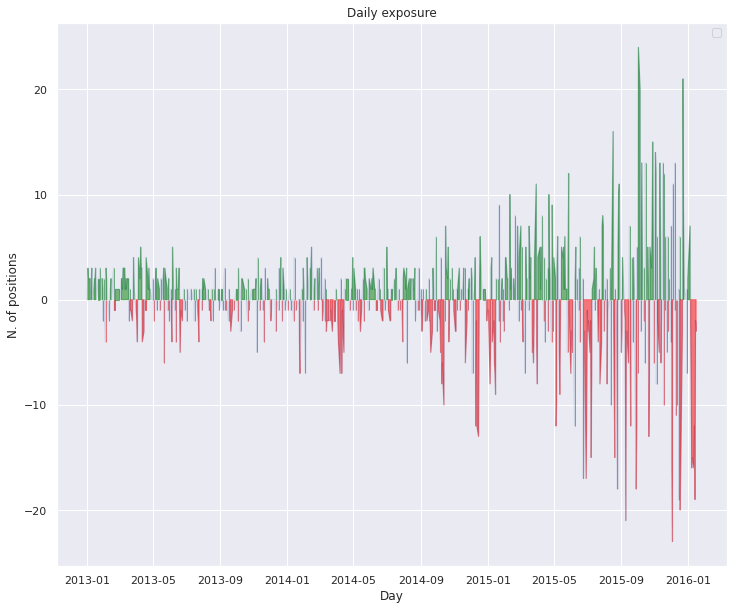

In [61]:
exits.plot(alpha=0.2)
plt.title('Daily exposure')
plt.xlabel('Day')
plt.ylabel('N. of positions')
plt.legend('')
plt.fill_between(exits.index.values, exits.values, 0, where=(exits > 0), color='green', alpha=0.5)
plt.fill_between(exits.index.values, exits.values, 0, where=(exits < 0), color='red', alpha=0.5)

ConversionError: Failed to convert value(s) to axis units: [Timestamp('2015-08-24 00:00:00'), nan]

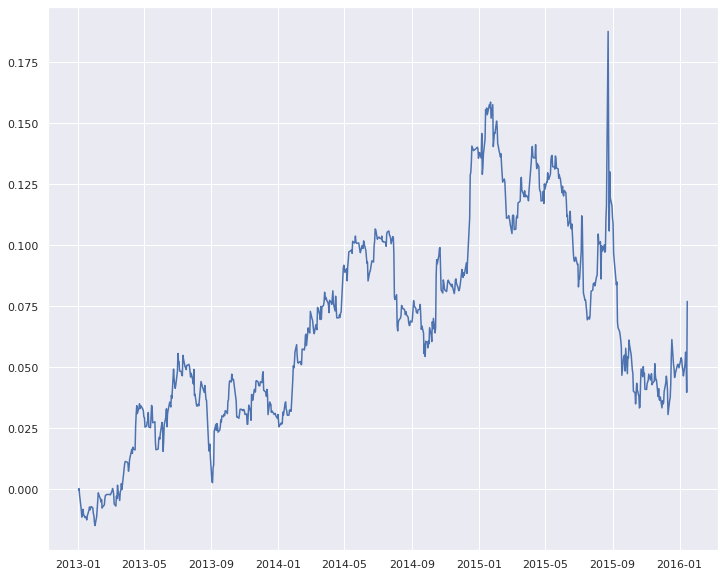

In [62]:
plt.plot(daily_ret_bndwv1.cumprod()-1)
end0 = top_dd[0][2]
end1 = datetime.datetime(2013, 12, 31)
plt.axvspan(top_dd[0][0], end0, facecolor='grey', alpha=0.5)
plt.axvspan(top_dd[1][0], top_dd[1][2], facecolor='grey', alpha=0.5)
plt.axvspan(top_dd[2][0], top_dd[2][2], facecolor='grey', alpha=0.5)


Text(0.5, 1.0, 'Rolling alpha and beta (1-month)')

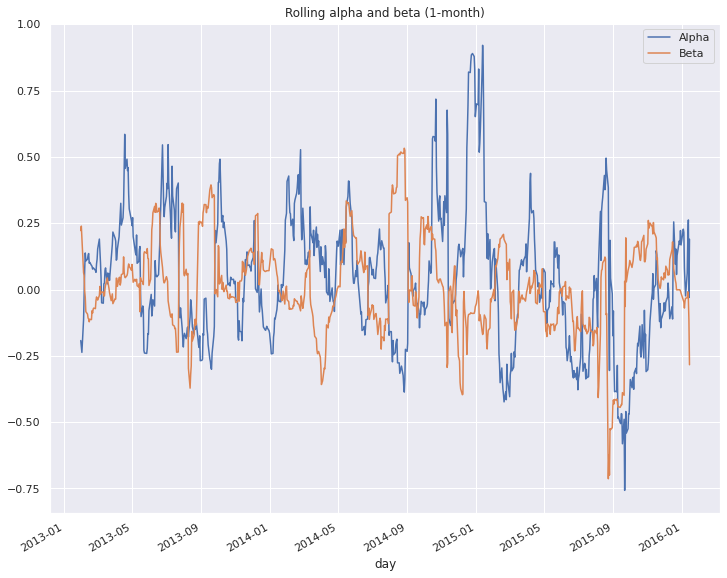

In [64]:
pf.timeseries.ep.roll_alpha_beta(daily_ret_bndwv1-1, s, window=21).plot()
plt.legend(['Alpha', 'Beta'])
plt.title('Rolling alpha and beta (1-month)')

In [65]:
pf.create_full_tear_sheet(daily_ret_bndwv1-1)

Start date,2013-01-02
End date,2016-01-15
Total months,37
,Backtest
Annual return,2.4%
Cumulative returns,7.7%
Annual volatility,8.2%
Sharpe ratio,0.33
Calmar ratio,0.18
Stability,0.39
Max drawdown,-13.2%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [66]:
Max_Daily_Drawdown_bndwv1.iloc[-1]

-0.13477230945427388

In [67]:
calmar_ratio = (daily_ret_bndwv1.cumprod()[-1]-1)/np.abs(Max_Daily_Drawdown_bndwv1.iloc[-1])
calmar_ratio

0.5717535093226022

In [68]:
treynor_ratio = (daily_ret_bndwv1.cumprod()[-1]-1)/beta
treynor_ratio

-1.3846415149724467

In [69]:
close_prices = Signal.Price[Signal.t.isin(strat_bndwv1_exit) & (Signal.strat_300.diff() != 0)].values

In [70]:
spread_max = 1/close_prices
spread_min = 0.05/close_prices

In [71]:
x = strat_bndwv1_exit.astype(np.datetime64)

In [72]:
y1 = ((pd.Series(strat_ret_bndwv1_close - spread_max, index=x).cumprod() - 1)*100)
y2 = ((pd.Series(strat_ret_bndwv1_close - spread_min, index=x).cumprod() - 1)*100)
y3 = ((pd.Series(strat_ret_bndwv1_close - 0.085/close_prices, index=x).cumprod() - 1)*100)

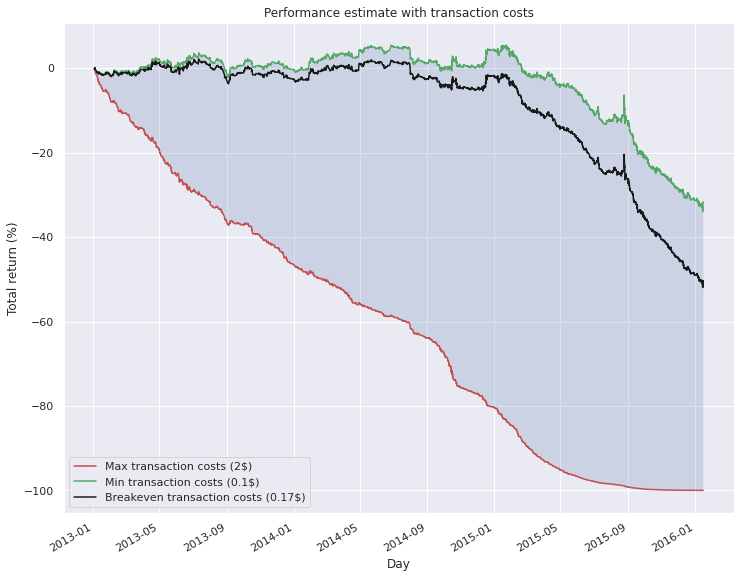

In [73]:
y1.plot(color='r')
y2.plot(color='g')
y3.plot(color='k')
plt.fill_between(x, y1.values, y2.values, alpha=0.2)
plt.ylabel('Total return (%)')
plt.xlabel('Day')
plt.title('Performance estimate with transaction costs')
plt.legend(['Max transaction costs (2$)', 'Min transaction costs (0.1$)', 'Breakeven transaction costs (0.17$)'])

<AxesSubplot:>

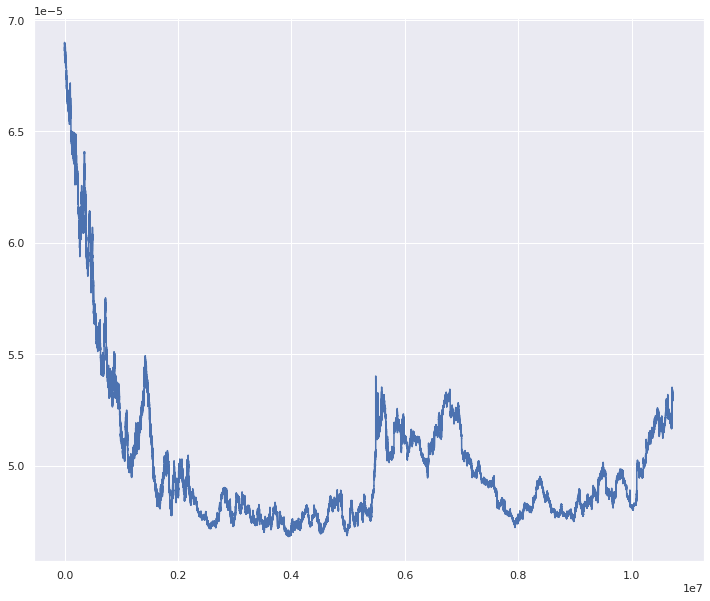

In [74]:
(0.1/Signal.Price).plot()